In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
from itertools import compress
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

Valid orders within 6 months in PL Shop (from 01/05/2018 to 30/11/2018) with a TC mapping

### Data loading, cleaning & formatting

In [2]:
data = pd.read_csv('6_months_orders_pl_shop_blacklisting_patterns_v2.dsv', sep=';', low_memory=False)

In [3]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ
0,516501185,26/10/2018 23:21:58,122041830,7195646,5779798,1710875,1,66608,"14,95","30,22",51,81-589
1,516501186,26/10/2018 23:21:58,122041830,7195646,5779798,1314392,1,61300,"16,2","30,22",51,81-589
2,516501187,26/10/2018 23:21:58,122041830,7195646,5779798,6,1,42715,"-0,93","30,22",51,81-589
3,469172969,07/05/2018 08:06:40,110157977,7195646,5779798,1339973,2,34165,0,"32,64",50,81-589
4,469172970,07/05/2018 08:06:40,110157977,7195646,5779798,1313313,1,61301,"21,2","32,64",50,81-589


In [4]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7018884 entries, 0 to 7018883
Data columns (total 12 columns):
OP_ID               int64
O_DATE              object
O_ID                int64
O_K_ID              int64
TC_ID               int64
OP_AS_ID            int64
OP_AMOUNT           int64
APS_AP_ID           int64
OP_PRICE            object
O_GWERT             object
OSP_KO_COUNT_NET    int64
OCI_PLZ             object
dtypes: int64(8), object(4)
memory usage: 642.6+ MB


In [5]:
# check duplicates at an order position level 6_months_orders_es_shop_blacklisting_patterns_v2.dsv

In [6]:
data = data[~data['OP_ID'].duplicated()]

In [7]:
data[~data['OP_ID'].duplicated()]['OP_ID'].nunique(), len(data)

(6345842, 6345842)

In [8]:
data['O_DATE'] = pd.to_datetime(data['O_DATE'], format="%d/%m/%Y %H:%M:%S")

In [9]:
data['O_DATE'].min(), data['O_DATE'].max()

(Timestamp('2018-05-01 00:00:00'), Timestamp('2018-11-30 23:59:56'))

In [10]:
data['OP_PRICE'] = [float(str(i).replace(',','.')) for i in data['OP_PRICE'].values]
data['O_GWERT'] = [float(str(i).replace(',','.')) for i in data['O_GWERT'].values]

In [11]:
data['OCI_PLZ'] = [str(i).replace(' ', '') for i in data['OCI_PLZ'].values]

In [12]:
data['MAX_SALES_O_POS'] = data['OP_PRICE'].groupby(data['O_ID']).transform('max')
data['IS_LEAD_AS'] = (data['OP_PRICE'] == data['MAX_SALES_O_POS']) * 1 * data['OP_AS_ID']
data['LEAD_AS_ID'] = data['IS_LEAD_AS'].groupby(data['O_ID']).transform('max')

In [13]:
arts_to_pgs = pd.read_csv('vw_ap_pg_link.dsv', sep=';', low_memory=False)

In [14]:
arts_to_pgs = arts_to_pgs.fillna(0).astype(int)[['AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']]
arts_to_pgs.head()

,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,7,3,33,1053
1,28,418,1248,1261
2,33,2,15,94
3,40,6,1635,1664
4,41,6,1635,3116


In [15]:
data = data.merge(arts_to_pgs, left_on='APS_AP_ID', right_on='AP_ID', how='left')

In [16]:
data.head()

,OP_ID,O_DATE,O_ID,O_K_ID,TC_ID,OP_AS_ID,OP_AMOUNT,APS_AP_ID,OP_PRICE,O_GWERT,OSP_KO_COUNT_NET,OCI_PLZ,MAX_SALES_O_POS,IS_LEAD_AS,LEAD_AS_ID,AP_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID
0,516501185,2018-10-26 23:21:58,122041830,7195646,5779798,1710875,1,66608,14.95,30.22,51,81-589,16.2,0,1314392,66608,3,252,201878
1,516501186,2018-10-26 23:21:58,122041830,7195646,5779798,1314392,1,61300,16.20,30.22,51,81-589,16.2,1314392,1314392,61300,3,252,261925
2,516501187,2018-10-26 23:21:58,122041830,7195646,5779798,6,1,42715,-0.93,30.22,51,81-589,16.2,0,1314392,42715,2,0,0
3,469172969,2018-05-07 08:06:40,110157977,7195646,5779798,1339973,2,34165,0.00,32.64,50,81-589,21.2,0,1313313,34165,3,33,498
4,469172970,2018-05-07 08:06:40,110157977,7195646,5779798,1313313,1,61301,21.20,32.64,50,81-589,21.2,1313313,1313313,61301,3,252,261925


In [17]:
data[['OP_AMOUNT', 'OSP_KO_COUNT_NET', 'LEAD_AS_ID', 'AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']] = \
data[['OP_AMOUNT', 'OSP_KO_COUNT_NET', 'LEAD_AS_ID', 'AP_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID']].fillna(0).astype(int)

### Order level

In [18]:
#Operations to do when grouping at order level
agg_ops = {'O_DATE': min,
          'O_K_ID': min, 
          'TC_ID': min,
          'OSP_KO_COUNT_NET': min,
          'O_GWERT': max,
          'APS_AP_ID': lambda x: list(x),
          'OP_AS_ID': [len, lambda x: list(x)],
          'OP_AMOUNT': lambda x: list(x),
          'LEAD_AS_ID': max,
          'L2_PG_ID': max,
          'L3_PG_ID': max,
          'L4_PG_ID': max,
          'OCI_PLZ': lambda x: list(set(list(x)))
          }

In [19]:
orders = data.groupby('O_ID', as_index=False).agg(agg_ops)

In [20]:
orders.columns = ['_'.join(tup).rstrip('_') for tup in orders.columns.values]

In [21]:
orders.columns = ['O_ID', 'O_DATE', 'O_K_ID', 'TC_ID', 'OSP_KO_COUNT_NET',
       'O_GWERT', 'APS_AP_ID_list', 'OP_AS_ID_len',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID',
       'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ']

In [22]:
orders.head()

,O_ID,O_DATE,O_K_ID,TC_ID,OSP_KO_COUNT_NET,O_GWERT,APS_AP_ID_list,OP_AS_ID_len,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ
0,109765662,2018-05-01 00:02:52,16679072,12312165,15,28.03,"[42715, 10794, 67360]",3,"[6, 284309, 1741471]","[1, 1, 1]",1741471,3,2068,218624,[25-344]
1,109765699,2018-05-01 00:00:00,10611602,8275693,21,117.35,"[1229, 61056, 53416, 11344, 73317, 33549, 5824...",8,"[2071773, 1308214, 1453090, 284922, 2138321, 1...","[1, 1, 1, 2, 1, 1, 1, 1]",1308214,2,857,250154,[47-200]
2,109765708,2018-05-01 00:00:25,18929311,13852016,4,26.20,[65518],1,[1587044],[1],1587044,2,251,74051,[64-600]
3,109765709,2018-05-01 00:00:25,3820895,402532,128,23.15,"[55166, 63088, 78333, 10794, 64848, 73339]",6,"[1374581, 1745429, 2393670, 284309, 1570080, 2...","[1, 2, 1, 1, 1, 1]",284309,3,301,95904,[32-600]
4,109765750,2018-05-01 00:05:18,17099405,12605092,25,35.25,"[62523, 72383, 64941]",3,"[1384238, 2105292, 1579964]","[1, 3, 1]",1579964,3,2068,97754,[42-400]


In [23]:
orders['OP_AS_ID_len'] = orders['OP_AS_ID_len'].fillna(0).astype(int)

In [24]:
orders['DATE_N_SV'] = [(i, j) for i, j in list(zip(orders['O_DATE'], orders['O_GWERT']))]

### Customer level

In [25]:
agg_ord_ops = {'O_ID': len,
              'O_DATE': lambda x: list(x),
              'TC_ID': lambda x: list(set(list(x))),
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'O_GWERT': [sum, lambda x: list(np.round(x, 2))],
              'DATE_N_SV': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID': lambda x: list(x),
              'L2_PG_ID': lambda x: list(x),
              'L3_PG_ID': lambda x: list(x),
              'L4_PG_ID': lambda x: list(x),
              'OCI_PLZ': lambda x: [item for sublist in x for item in sublist]
              }

In [26]:
customers_ = orders.groupby('O_K_ID', as_index=False).agg(agg_ord_ops).round(2)

In [27]:
customers_.columns

MultiIndex(levels=[['O_ID', 'O_DATE', 'TC_ID', 'OSP_KO_COUNT_NET', 'O_GWERT', 'DATE_N_SV', 'APS_AP_ID_list', 'OP_AS_ID_len', 'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID', 'OCI_PLZ', 'O_K_ID'], ['<lambda>', 'len', 'sum', '']],
           labels=[[15, 0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], [3, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
customers_.columns = ['_'.join(tup).rstrip('_') for tup in customers_.columns.values]

In [29]:
 customers_.columns = ['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID',
       'OSP_KO_COUNT_NET_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list']

In [30]:
customers_['TC_ID'] = [i[0] for i in customers_['TC_ID'].values]

In [31]:
customers_['O_K_COUNTER_MAX'] = [max(i) for i in customers_['OSP_KO_COUNT_NET_list'].values]

In [32]:
customers_.sample(5)

,O_K_ID,O_ID_len,O_DATE_list,TC_ID,OSP_KO_COUNT_NET_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID_list,L2_PG_ID_list,L3_PG_ID_list,L4_PG_ID_list,OCI_PLZ_list,O_K_COUNTER_MAX
249084,18542360,10,"[2018-05-20 18:04:41, 2018-05-27 16:05:04, 201...",13591103,"[12, 13, 13, 13, 14, 15, 16, 17, 18, 19]",395.32,"[34.03, 25.54, 31.2, 35.81, 25.54, 40.75, 34.6...","[(2018-05-20 18:04:41, 34.03), (2018-05-27 16:...","[[55023, 79317, 70133, 56627, 16079, 42715], [...","[6, 4, 4, 5, 4, 4, 8, 5, 8, 5]","[[1093709, 2409857, 2015996, 1196745, 2110414,...","[[1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [3, 1, 1, 1...","[1093709, 1660987, 1660692, 2339361, 1660987, ...","[3, 3, 3, 3, 3, 3, 3, 3, 447, 3]","[2155, 252, 252, 301, 252, 252, 301, 301, 4896...","[108362, 95904, 95904, 97754, 95904, 95904, 97...","[01-059, 01-357, 01-059, 01-357, 01-464, 01-05...",19
9429,3785652,2,"[2018-05-19 18:24:02, 2018-09-02 11:07:28]",14221730,"[34, 35]",121.15,"[51.6, 69.55]","[(2018-05-19 18:24:02, 51.6), (2018-09-02 11:0...","[[10141, 61247, 34165, 10947], [10141, 33082, ...","[4, 4]","[[280944, 1316382, 1339973, 284268], [280944, ...","[[1, 1, 1, 1], [1, 1, 1, 1]]","[1316382, 1316382]","[3, 3]","[2068, 2068]","[2096, 2096]","[55-093, 55-093]",35
201290,16844985,4,"[2018-05-10 20:49:08, 2018-06-22 18:52:10, 201...",12428101,"[7, 8, 9, 10]",204.30,"[39.95, 40.7, 41.2, 82.45]","[(2018-05-10 20:49:08, 39.95), (2018-06-22 18:...","[[64485, 61095], [61095, 64485], [80637], [806...","[2, 2, 1, 2]","[[1781906, 2400984], [1300741, 1781906], [2416...","[[1, 1], [1, 1], [1], [1, 1]]","[2400984, 1300741, 2416550, 2416551]","[2, 2, 2, 2]","[251, 251, 251, 857]","[1306, 1306, 682, 6530]","[82-500, 82-500, 82-500, 82-500]",10
435234,21778613,1,[2018-11-06 09:37:32],16327234,[1],15.85,[15.85],"[(2018-11-06 09:37:32, 15.85)]","[[6169, 5784, 367, 52189, 6168]]",[5],"[[1, 283546, 281720, 932108, 2]]","[[1, 1, 2, 1, 1]]",[932108],[5],[274],[42317],[03-710],1
395267,21294486,2,"[2018-09-18 11:26:20, 2018-10-01 06:52:51]",15878310,"[1, 2]",69.85,"[25.25, 44.6]","[(2018-09-18 11:26:20, 25.25), (2018-10-01 06:...","[[59841, 65110, 48617, 55406, 79749], [59842, ...","[5, 12]","[[1364157, 1639589, 867987, 1211017, 2407861],...","[[1, 1, 1, 1, 1], [1, 1, 1, 2, 1, 1, 1, 1, 1, ...","[867987, 867987]","[3, 3]","[2068, 301]","[2125, 71979]","[01-172, 01-172]",2


### True customer level

In [33]:
mask = [type(i) == list for i in customers_['OCI_PLZ_list'].values]

In [34]:
sum(mask), len(customers_)

(459354, 459354)

In [35]:
customers_.columns

Index(['O_K_ID', 'O_ID_len', 'O_DATE_list', 'TC_ID', 'OSP_KO_COUNT_NET_list',
       'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list',
       'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list', 'L4_PG_ID_list',
       'OCI_PLZ_list', 'O_K_COUNTER_MAX'],
      dtype='object')

In [36]:
agg_ord_ops = {'O_ID_len': sum,
              'O_DATE_list': lambda x: list(x),
              'O_K_ID': lambda x: list(x),
              'OSP_KO_COUNT_NET_list': lambda x: list(x),
              'O_K_COUNTER_MAX': lambda x: list(x),
              'O_GWERT_sum': sum, 
              'O_GWERT_list': lambda x: list(x),
              'DATE_N_SV_list': lambda x: list(x),
              'APS_AP_ID_list': lambda x: list(x),
              'OP_AS_ID_len_list': lambda x: list(x),
              'OP_AS_ID_list': lambda x: list(x),
              'OP_AMOUNT_list': lambda x: list(x),
              'LEAD_AS_ID_list': lambda x: list(x),
              'L2_PG_ID_list': lambda x: list(x),
              'L3_PG_ID_list': lambda x: list(x),
              'L4_PG_ID_list': lambda x: list(x),
              'OCI_PLZ_list': lambda x: list(x)
              }

In [37]:
customers = customers_.groupby('TC_ID', as_index=False).agg(agg_ord_ops).round(2)

In [38]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID', 'OSP_KO_COUNT_NET_list',
       'O_K_COUNTER_MAX', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list',
       'OP_AMOUNT_list', 'LEAD_AS_ID_list', 'L2_PG_ID_list', 'L3_PG_ID_list',
       'L4_PG_ID_list', 'OCI_PLZ_list'],
      dtype='object')

In [38]:
#customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [39]:
customers.columns = ['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum', 'O_GWERT_list', 'DATE_N_SV_list',
       'APS_AP_ID_list', 'OP_AS_ID_len_list', 'OP_AS_ID_list', 'OP_AMOUNT_list',
       'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID', 'L4_PG_ID',
       'OCI_PLZ_list']

In [40]:
customers['O_DATE_list'] = [sorted([k for j in i for k in j]) for i in customers['O_DATE_list'].values]

In [41]:
customers['DATE_N_SV_list'] = [sorted([k for j in i for k in j], key=lambda x:x[0]) for i in customers['DATE_N_SV_list'].values]

In [42]:
customers['OSP_KO_COUNT_NET_list'] = [[k for j in i for k in j] for i in customers['OSP_KO_COUNT_NET_list'].values]

In [43]:
customers['O_GWERT_list'] = [[k for j in i for k in j] for i in customers['O_GWERT_list'].values]

In [44]:
customers['OP_AS_ID_len_list'] = [[j for j in i] for i in customers['OP_AS_ID_len_list'].values]

In [45]:
customers['LEAD_AS_ID'] = [Counter([k for j in i for k in j]) for i in customers['LEAD_AS_ID'].values]

In [46]:
customers['L2_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L2_PG_ID'].values]

In [47]:
customers['L3_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L3_PG_ID'].values]

In [48]:
customers['L4_PG_ID'] = [Counter([k for j in i for k in j]) for i in customers['L4_PG_ID'].values]

In [49]:
customers['OCI_PLZ_list'] = [Counter([k for j in i for k in j]) for i in customers['OCI_PLZ_list'].values]

In [50]:
customers['APS_AP_ID_list'] = [[k for j in i for k in j] for i in customers['APS_AP_ID_list'].values]

In [51]:
customers['OP_AS_ID_len_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_len_list'].values]

In [52]:
customers['OP_AS_ID_list'] = [[k for j in i for k in j] for i in customers['OP_AS_ID_list'].values]

In [53]:
customers['OP_AMOUNT_list'] = [[k for j in i for k in j] for i in customers['OP_AMOUNT_list'].values]

In [54]:
customers.sample(5)

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,OP_AS_ID_len_list,OP_AS_ID_list,OP_AMOUNT_list,LEAD_AS_ID,L2_PG_ID,L3_PG_ID,L4_PG_ID,OCI_PLZ_list
370453,15624831,1,[2018-08-19 20:03:09],[21023489],[1],[1],14.95,[14.95],"[(2018-08-19 20:03:09, 14.95)]","[[63385, 6168]]",[2],"[[1468914, 2]]","[[1, 1]]",{1468914: 1},{2: 1},{9: 1},{74: 1},{'52-244': 1}
307810,14562918,6,"[2018-05-27 22:07:25, 2018-07-07 07:33:32, 201...",[19881676],"[3, 4, 5, 6, 7, 9]",[9],233.56,"[30.67, 30.96, 30.67, 40.75, 46.27, 54.24]","[(2018-05-27 22:07:25, 30.67), (2018-07-07 07:...","[[73732, 42715], [72598, 42715], [81762, 42715...","[2, 2, 2, 2, 2, 2]","[[2162399, 6], [2360939, 6], [2428338, 6], [24...","[[1, 1], [1, 1], [1, 1], [3, 1], [1, 1], [2, 1]]","{2162399: 1, 2360939: 1, 2428338: 1, 2480924: ...",{3: 6},"{2068: 5, 252: 1}","{2071: 5, 81397: 1}",{'96-100': 6}
61181,4571369,1,[2018-09-03 21:19:36],[5494693],[10],[10],40.65,[40.65],"[(2018-09-03 21:19:36, 40.65)]","[[67214, 82043]]",[2],"[[1838965, 2451167]]","[[1, 1]]",{2451167: 1},{2: 1},{251: 1},{74051: 1},{'78-100': 1}
177135,10868722,1,[2018-09-20 17:31:31],[14585914],[14],[14],23.65,[23.65],"[(2018-09-20 17:31:31, 23.65)]","[[52417, 52142, 52143]]",[3],"[[1054773, 912982, 912983]]","[[1, 1, 1]]",{912983: 1},{3: 1},{34: 1},{71978: 1},{'86-300': 1}
351957,15353674,1,[2018-07-16 10:30:15],[20733027],[1],[1],34.85,[34.85],"[(2018-07-16 10:30:15, 34.85)]","[[76800, 77014, 74373, 21449, 74652, 61705, 75...",[9],"[[2337677, 2234535, 2190385, 311609, 2443892, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1]]",{1357890: 1},{2: 1},{153317: 1},{250154: 1},{'40-375': 1}


In [55]:
customers['O_TIMEDELTAS'] = [[(i.date() - j.date()).days for i, j in list(zip(o_list[1:], o_list[:-1]))] for o_list in customers['O_DATE_list'].values]

In [55]:
#customers['OCI_PLZ'] = [Counter([j[0] for j in i]) for i in customers['OCI_PLZ'].values]

In [56]:
#customers.to_pickle("./customers_pl.pkl")

In [2]:
customers = pd.read_pickle("./customers_pl.pkl")

In [3]:
orders_per_customer = [i for i in customers['O_ID_len'].values]
timedeltas_between_orders = [j for i in customers['O_TIMEDELTAS'].values for j in i]
set_zipcodes_per_customer = [len(i.keys()) for i in customers['OCI_PLZ_list'].values]

In [4]:
total_sales_values = [i for i in customers['O_GWERT_sum'].values]

In [5]:
basket_values = [j for i in customers['O_GWERT_list'].values for j in i]
items_per_order = [sum(j) for i in customers['OP_AMOUNT_list'].values for j in i]

In [6]:
animals_per_customer = [len(i.keys()) for i in customers['L2_PG_ID'].values]
lead_prod_groups_3_per_customer = [len(i.keys()) for i in customers['L3_PG_ID'].values]
brands_per_customer = [len(i.keys()) for i in customers['L4_PG_ID'].values]
arts_shop_per_customer = [len(i.keys()) for i in customers['LEAD_AS_ID'].values]

In [7]:
order_positions_per_order= [j for i in customers['OP_AS_ID_len_list'].values for j in i]

In [8]:
#New features
arts_shop_orders_ratio_per_customer = [np.round(len(i.keys()) / j, 3) for i, j in list(zip(customers['LEAD_AS_ID'].values,
                                                                       customers['O_ID_len'].values))]

In [9]:
max_order_counter_per_customer = [sum(i) for i in customers['O_K_COUNTER_MAX_list'].values]

### Features & histograms

#### Orders per true customer

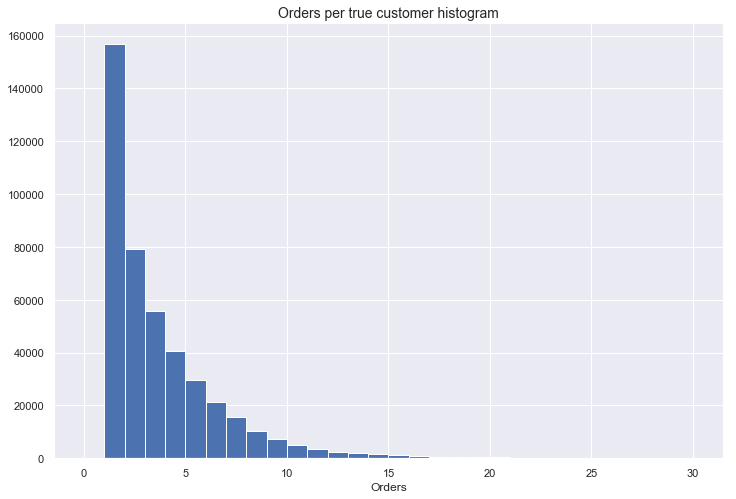

In [65]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(orders_per_customer, bins=30, range=(0, 30))
plt.xlabel('Orders')
plt.title('Orders per true customer histogram', fontsize=14)
plt.show()

In [66]:
Counter(orders_per_customer), np.percentile(orders_per_customer, 99.9)

(Counter({1: 156758,
          2: 79060,
          3: 55753,
          4: 40677,
          5: 29459,
          6: 21179,
          7: 15780,
          8: 10435,
          9: 7124,
          10: 4908,
          11: 3587,
          12: 2559,
          13: 1840,
          14: 1452,
          15: 1085,
          16: 819,
          17: 627,
          18: 494,
          19: 454,
          20: 314,
          21: 277,
          22: 204,
          23: 185,
          24: 158,
          25: 151,
          26: 118,
          27: 87,
          28: 99,
          29: 81,
          30: 72,
          31: 71,
          32: 71,
          33: 51,
          34: 42,
          35: 46,
          36: 29,
          37: 41,
          38: 36,
          39: 24,
          40: 20,
          41: 26,
          42: 28,
          43: 27,
          44: 19,
          45: 20,
          46: 21,
          47: 13,
          48: 16,
          49: 20,
          50: 20,
          51: 9,
          52: 13,
          53: 7,
       

#### Timedeltas between orders

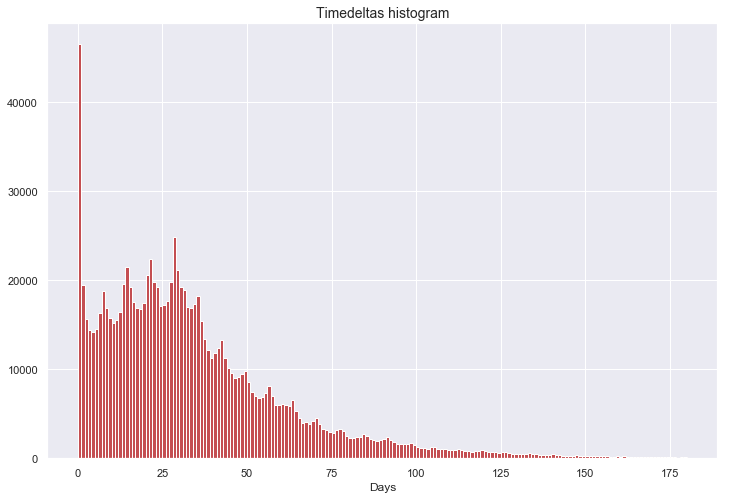

In [67]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(timedeltas_between_orders, bins=180, range=(0, 180), color='r')
plt.xlabel('Days')
plt.title('Timedeltas histogram', fontsize=14)
plt.show()

In [68]:
np.percentile(timedeltas_between_orders, 10)

4.0

#### Delivery zipcodes per true customer

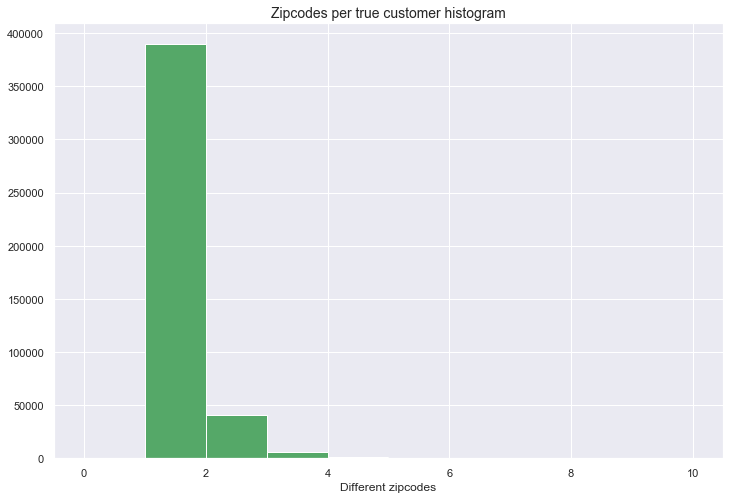

In [69]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(set_zipcodes_per_customer, bins=10, range=(0, 10), color='g')
plt.xlabel('Different zipcodes')
plt.title('Zipcodes per true customer histogram', fontsize=14)
plt.show()

In [70]:
Counter(set_zipcodes_per_customer), np.percentile(set_zipcodes_per_customer, 99.9)

(Counter({1: 389714,
          2: 40322,
          3: 5493,
          4: 840,
          5: 193,
          6: 96,
          7: 26,
          8: 30,
          9: 15,
          10: 6,
          11: 11,
          12: 8,
          13: 12,
          14: 4,
          15: 3,
          16: 4,
          17: 3,
          18: 3,
          19: 2,
          20: 1,
          21: 3,
          24: 2,
          25: 1,
          33: 1,
          36: 1,
          62: 1,
          427: 1,
          874: 1}),
 4.0)

#### Basket Values

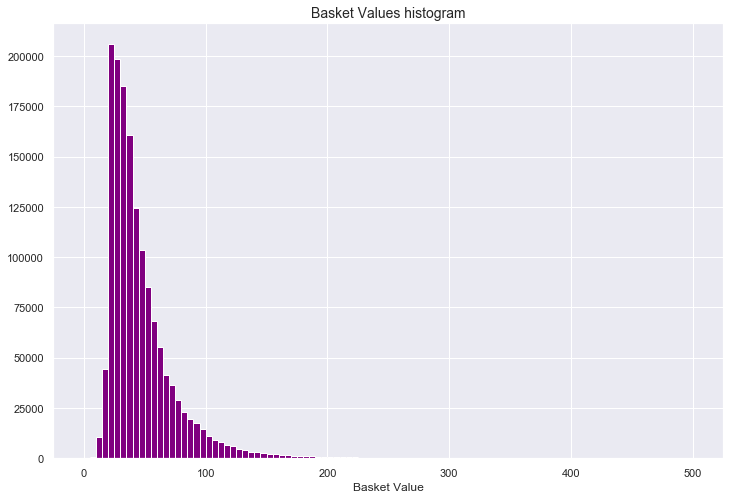

In [71]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(basket_values, bins=100, range=(0, 500), color='purple')
plt.xlabel('Basket Value')
plt.title('Basket Values histogram', fontsize=14)
plt.show()

In [72]:
np.percentile(basket_values, 99.5)

223.87

#### Total sales value

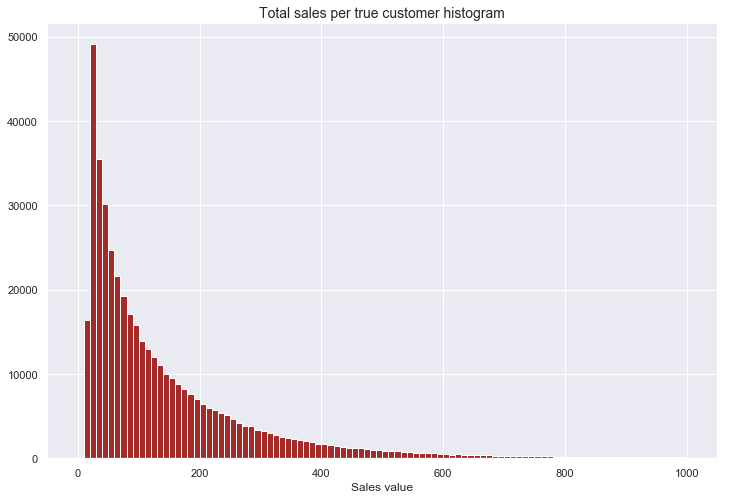

In [73]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(total_sales_values, bins=100, range=(0, 1000), color='brown')
plt.xlabel('Sales value')
plt.title('Total sales per true customer histogram', fontsize=14)
plt.show()

In [74]:
np.max(total_sales_values), np.percentile(total_sales_values, 99.9)

(360480.25, 3520.3225600002334)

#### Items per order

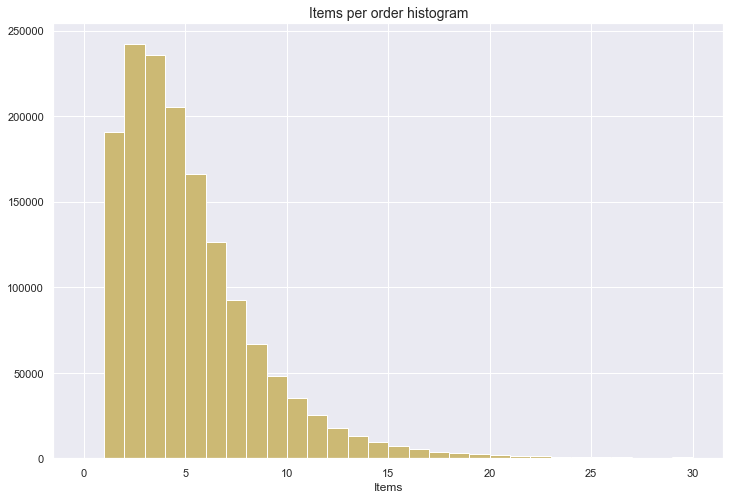

In [75]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(items_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Items')
plt.title('Items per order histogram', fontsize=14)
plt.show()

In [76]:
Counter(items_per_order), np.percentile(items_per_order, 99.9)

(Counter({1: 190586,
          2: 242081,
          3: 235454,
          4: 205363,
          5: 165944,
          6: 126666,
          7: 92373,
          8: 66979,
          9: 48070,
          10: 35196,
          11: 25296,
          12: 17907,
          13: 13000,
          14: 9298,
          15: 7097,
          16: 5336,
          17: 3947,
          18: 2971,
          19: 2387,
          20: 1933,
          21: 1542,
          22: 1187,
          23: 967,
          24: 778,
          25: 626,
          26: 520,
          27: 423,
          28: 359,
          29: 310,
          30: 256,
          31: 219,
          32: 197,
          33: 157,
          34: 143,
          35: 115,
          36: 108,
          37: 98,
          38: 60,
          39: 73,
          40: 79,
          41: 55,
          42: 34,
          43: 44,
          44: 41,
          45: 37,
          46: 32,
          47: 31,
          48: 23,
          49: 26,
          50: 23,
          51: 17,
          52: 

#### Order positions per order

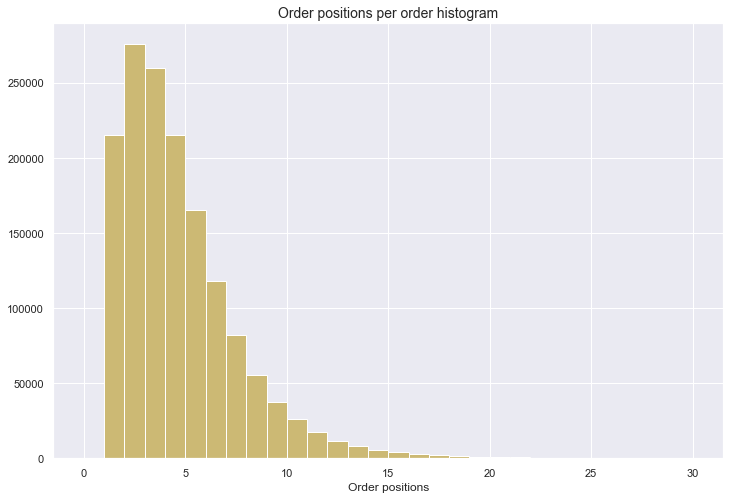

In [77]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(order_positions_per_order, bins=30, range=(0, 30), color='y')
plt.xlabel('Order positions')
plt.title('Order positions per order histogram', fontsize=14)
plt.show()

In [78]:
Counter(order_positions_per_order), np.percentile(order_positions_per_order, 99.9)

(Counter({1: 214993,
          2: 275582,
          3: 259653,
          4: 214767,
          5: 164920,
          6: 117953,
          7: 81889,
          8: 55527,
          9: 37686,
          10: 25954,
          11: 17420,
          12: 11692,
          13: 7976,
          14: 5507,
          15: 3942,
          16: 2778,
          17: 2025,
          18: 1458,
          19: 1121,
          20: 854,
          21: 651,
          22: 451,
          23: 371,
          24: 294,
          25: 225,
          26: 183,
          27: 148,
          28: 127,
          29: 93,
          30: 75,
          31: 53,
          32: 54,
          33: 43,
          34: 43,
          35: 31,
          36: 28,
          37: 25,
          38: 23,
          39: 12,
          40: 14,
          41: 10,
          42: 10,
          43: 3,
          44: 10,
          45: 6,
          46: 2,
          47: 5,
          48: 5,
          49: 5,
          50: 5,
          51: 2,
          52: 5,
          53: 2,


#### Different animals - Lead PG2- per true customer

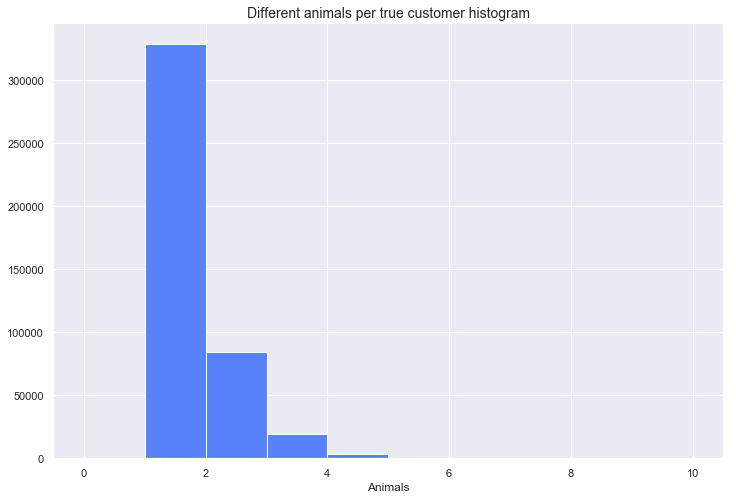

In [79]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(animals_per_customer, bins=10, range=(0, 10), color='#5882FA')
plt.xlabel('Animals')
plt.title('Different animals per true customer histogram', fontsize=14)
plt.show()

In [80]:
np.max(animals_per_customer), np.percentile(animals_per_customer, 99)

(7, 4.0)

In [81]:
Counter(animals_per_customer)

Counter({1: 328473, 2: 84291, 3: 19652, 4: 3680, 5: 614, 6: 78, 7: 9})

#### Different Lead PG3 per true customer

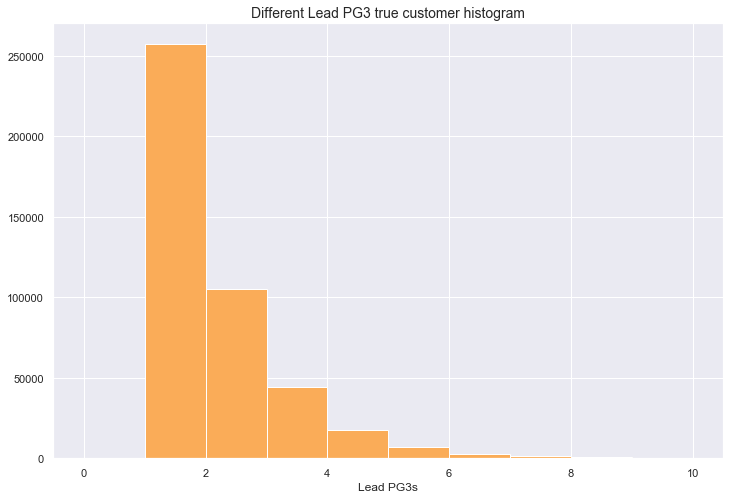

In [82]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(lead_prod_groups_3_per_customer, bins=10, range=(0, 10), color='#FAAC58')
plt.xlabel('Lead PG3s')
plt.title('Different Lead PG3 true customer histogram', fontsize=14)
plt.show()

In [83]:
np.max(lead_prod_groups_3_per_customer), np.percentile(lead_prod_groups_3_per_customer, 99.9)

(43, 9.0)

In [84]:
Counter(lead_prod_groups_3_per_customer)

Counter({1: 257378,
         2: 104960,
         3: 44567,
         4: 17833,
         5: 6829,
         6: 2871,
         7: 1179,
         8: 570,
         9: 258,
         10: 135,
         11: 72,
         12: 55,
         13: 31,
         14: 25,
         15: 10,
         16: 8,
         17: 3,
         18: 2,
         19: 3,
         20: 4,
         21: 2,
         24: 1,
         43: 1})

#### Brands -Lead PG4- per true customer

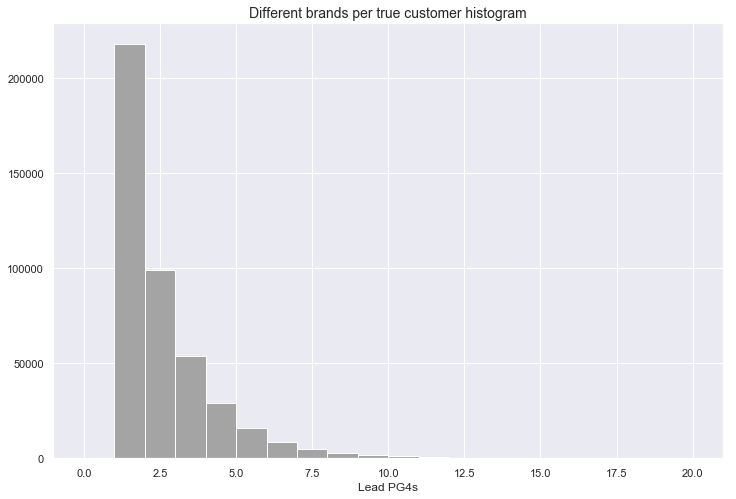

In [85]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(brands_per_customer, bins=20, range=(0, 20), color='#A4A4A4')
plt.xlabel('Lead PG4s')
plt.title('Different brands per true customer histogram', fontsize=14)
plt.show()

In [86]:
np.max(brands_per_customer), np.percentile(brands_per_customer, 99.9)

(278, 19.0)

In [87]:
Counter(brands_per_customer)

Counter({1: 218018,
         2: 99169,
         3: 53880,
         4: 28960,
         5: 15751,
         6: 8649,
         7: 4765,
         8: 2620,
         9: 1508,
         10: 1003,
         11: 615,
         12: 394,
         13: 282,
         14: 206,
         15: 170,
         16: 111,
         17: 124,
         18: 78,
         19: 62,
         20: 47,
         21: 43,
         22: 39,
         23: 27,
         24: 36,
         25: 18,
         26: 16,
         27: 21,
         28: 29,
         29: 13,
         30: 13,
         31: 11,
         32: 13,
         33: 13,
         34: 4,
         35: 8,
         36: 5,
         37: 8,
         38: 5,
         39: 5,
         40: 2,
         41: 7,
         42: 4,
         43: 3,
         44: 3,
         45: 5,
         46: 1,
         47: 3,
         48: 4,
         49: 1,
         50: 2,
         51: 3,
         52: 2,
         53: 1,
         54: 2,
         55: 1,
         56: 1,
         57: 1,
         59: 2,
         62: 1,

#### Different lead shop articles per customer

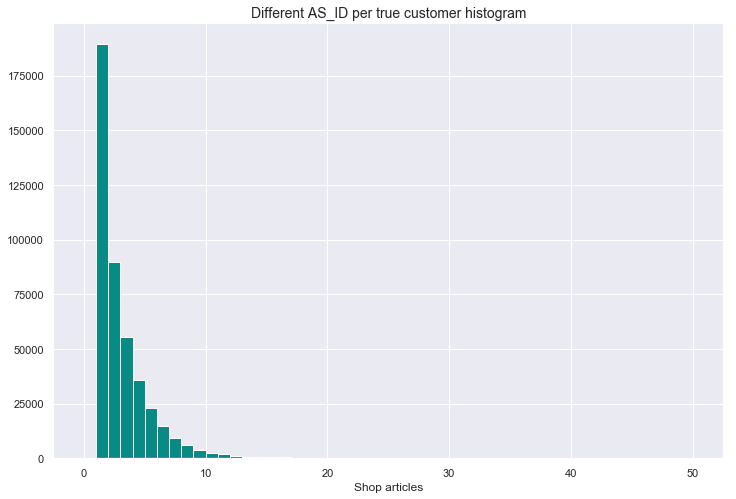

In [88]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_per_customer, bins=50, range=(0, 50), color='#088A85')
plt.xlabel('Shop articles')
plt.title('Different AS_ID per true customer histogram', fontsize=14)
plt.show()

In [89]:
Counter(arts_shop_per_customer), np.percentile(arts_shop_per_customer, 99.9)

(Counter({1: 189378,
          2: 89744,
          3: 55569,
          4: 35603,
          5: 22798,
          6: 14928,
          7: 9361,
          8: 6054,
          9: 3760,
          10: 2558,
          11: 1786,
          12: 1179,
          13: 798,
          14: 637,
          15: 430,
          16: 347,
          17: 243,
          18: 196,
          19: 179,
          20: 126,
          21: 105,
          22: 97,
          23: 92,
          24: 83,
          25: 56,
          26: 58,
          27: 48,
          28: 32,
          29: 31,
          30: 35,
          31: 28,
          32: 18,
          33: 33,
          34: 12,
          35: 22,
          36: 26,
          37: 15,
          38: 20,
          39: 15,
          40: 15,
          41: 20,
          42: 14,
          43: 13,
          44: 8,
          45: 4,
          46: 9,
          47: 5,
          48: 9,
          49: 4,
          50: 7,
          51: 7,
          52: 6,
          53: 9,
          54: 5,
        

#### Ratio Different Lead AS_ID / Orders 

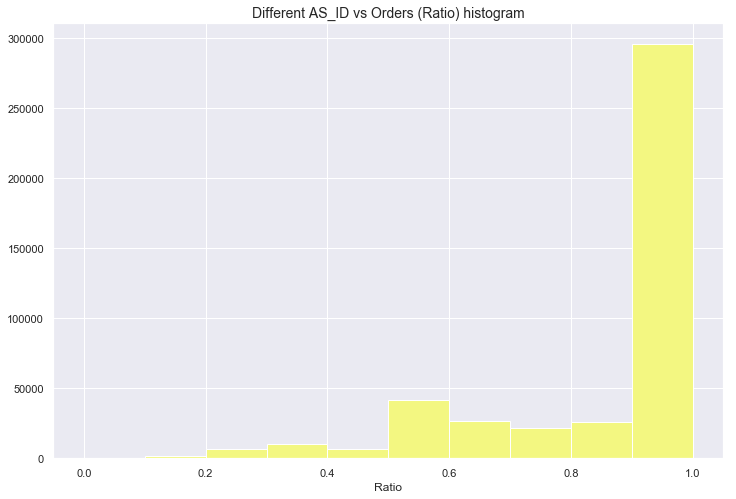

In [90]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(arts_shop_orders_ratio_per_customer, bins=10, range=(0, 1), color='#F3F781')
plt.xlabel('Ratio')
plt.title('Different AS_ID vs Orders (Ratio) histogram', fontsize=14)
plt.show()

In [91]:
Counter(arts_shop_orders_ratio_per_customer), np.percentile(arts_shop_orders_ratio_per_customer, 99)

(Counter({0.043: 1,
          0.056: 2,
          0.062: 1,
          0.071: 6,
          0.077: 9,
          0.083: 7,
          0.091: 19,
          0.1: 43,
          0.111: 76,
          0.118: 4,
          0.119: 1,
          0.125: 165,
          0.133: 5,
          0.136: 1,
          0.143: 428,
          0.15: 2,
          0.154: 21,
          0.158: 1,
          0.167: 852,
          0.176: 6,
          0.182: 69,
          0.184: 1,
          0.185: 1,
          0.188: 5,
          0.189: 1,
          0.2: 1703,
          0.208: 1,
          0.211: 1,
          0.214: 19,
          0.217: 2,
          0.222: 198,
          0.225: 2,
          0.227: 2,
          0.229: 1,
          0.231: 41,
          0.233: 2,
          0.235: 9,
          0.238: 3,
          0.241: 1,
          0.242: 1,
          0.244: 1,
          0.25: 3616,
          0.258: 3,
          0.263: 5,
          0.267: 18,
          0.268: 1,
          0.273: 108,
          0.278: 9,
          0.28: 2,
   

#### Max order counter per customer

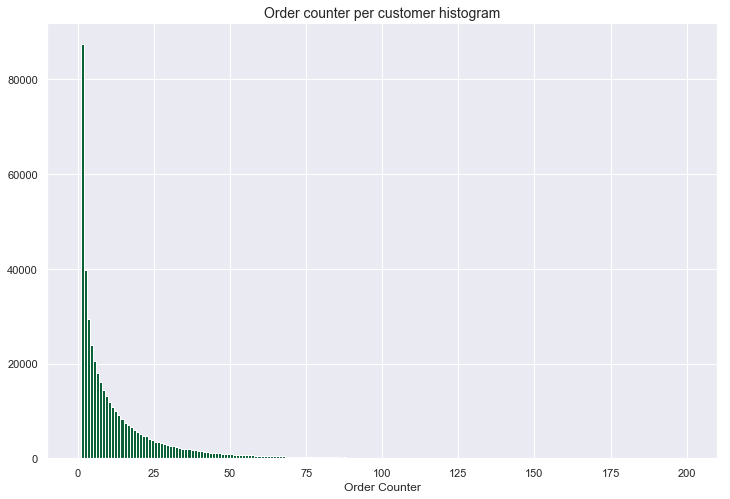

In [92]:
sns.set()
plt.figure(figsize=(12,8))
plt.hist(max_order_counter_per_customer, bins=200, range=(0, 200), color='#0B6138')
plt.xlabel('Order Counter')
plt.title('Order counter per customer histogram', fontsize=14)
plt.show()

In [93]:
Counter(max_order_counter_per_customer).most_common(), np.percentile(max_order_counter_per_customer, 99.9)

([(1, 87423),
  (2, 39817),
  (3, 29317),
  (4, 24020),
  (5, 20510),
  (6, 17953),
  (7, 16065),
  (8, 14340),
  (9, 13103),
  (10, 11870),
  (11, 10888),
  (12, 10008),
  (13, 9090),
  (14, 8347),
  (15, 7496),
  (16, 6967),
  (17, 6556),
  (18, 5924),
  (19, 5484),
  (20, 5129),
  (21, 4670),
  (22, 4637),
  (23, 4122),
  (24, 3884),
  (25, 3542),
  (26, 3415),
  (27, 3233),
  (28, 3081),
  (29, 2711),
  (30, 2570),
  (31, 2548),
  (32, 2300),
  (33, 2158),
  (34, 1971),
  (35, 1905),
  (36, 1899),
  (37, 1722),
  (38, 1695),
  (40, 1477),
  (39, 1476),
  (41, 1393),
  (42, 1368),
  (43, 1222),
  (45, 1132),
  (44, 1118),
  (46, 1054),
  (47, 981),
  (49, 947),
  (48, 919),
  (50, 850),
  (51, 802),
  (52, 754),
  (53, 686),
  (55, 682),
  (54, 673),
  (56, 617),
  (57, 617),
  (58, 570),
  (59, 534),
  (61, 528),
  (60, 519),
  (62, 482),
  (63, 458),
  (65, 432),
  (67, 391),
  (64, 387),
  (66, 384),
  (68, 350),
  (69, 349),
  (70, 336),
  (74, 314),
  (73, 313),
  (72, 312),
  

### Outlier detection based on percentiles

In [10]:
customers.columns

Index(['TC_ID', 'O_ID_len', 'O_DATE_list', 'O_K_ID_list',
       'OSP_KO_COUNT_NET_list', 'O_K_COUNTER_MAX_list', 'O_GWERT_sum',
       'O_GWERT_list', 'DATE_N_SV_list', 'APS_AP_ID_list', 'OP_AS_ID_len_list',
       'OP_AS_ID_list', 'OP_AMOUNT_list', 'LEAD_AS_ID', 'L2_PG_ID', 'L3_PG_ID',
       'L4_PG_ID', 'OCI_PLZ_list', 'O_TIMEDELTAS'],
      dtype='object')

We define here the percentiles of each feature for testing just within our data...

In [11]:
features_percentiles = [np.percentile(orders_per_customer, 99.95), np.percentile(timedeltas_between_orders, 5), 
                                np.percentile(set_zipcodes_per_customer, 99.95), np.percentile(total_sales_values, 99.95), 
                                np.percentile(basket_values, 99.95), np.percentile(items_per_order, 99.95),
                                np.percentile(order_positions_per_order, 99.95),
                                np.percentile(arts_shop_per_customer, 99.95), np.rint(np.percentile(max_order_counter_per_customer, 99.95))]

In [12]:
features_percentiles

[67.0,
 1.0,
 6.0,
 5545.123780000066,
 500.16570499999915,
 39.0,
 27.0,
 46.0,
 343.0]

In [13]:
features_percentiles = pd.DataFrame([features_percentiles], columns=['ORDERS', 
                                                                'TD_PER_ORDER', 'ZIPCODES', 'TOTAL_SALES', 
                                                                'BASKET_VALUE', 'ITEMS_PER_ORDER','O_POS_PER_ORDER',
                                                                'LEAD_AS_IDs', 'ORDER_COUNTER'])

In [14]:
features_percentiles

,ORDERS,TD_PER_ORDER,ZIPCODES,TOTAL_SALES,BASKET_VALUE,ITEMS_PER_ORDER,O_POS_PER_ORDER,LEAD_AS_IDs,ORDER_COUNTER
0,67.0,1.0,6.0,5545.12378,500.165705,39.0,27.0,46.0,343.0


In [15]:
features_percentiles['TD_PER_ORDER'].values[0]

1.0

We define using a binary classification (0, 1) if the customer or one of his orders is considered as outlier for each of the features tested...

In [16]:
# Variables to check per true customer: orders, different delivery zipcodes, total sales, different lead pg2/pg3/pg4

In [17]:
customers['OUTL_ORDERS'] = [(i > features_percentiles['ORDERS'].values[0]) * 1 for i in customers['O_ID_len'].values]

In [18]:
customers['OUTL_OCI_PLZ'] = [(len(i.keys()) > features_percentiles['ZIPCODES'].values[0]) * 1 for i in customers['OCI_PLZ_list'].values]

In [19]:
customers['OUTL_TOT_O_GWERT'] = [(i > features_percentiles['TOTAL_SALES'].values[0]) * 1 for i in customers['O_GWERT_sum'].values]

In [20]:
#customers['OUTL_PG2'] = [(len(i.keys()) > features_percentiles['PG2'].values[0]) * 1 for i in customers['L2_PG_ID'].values]

In [21]:
#customers['OUTL_PG3'] = [(len(i.keys()) > features_percentiles['PG3'].values[0]) * 1 for i in customers['L3_PG_ID'].values]

In [22]:
#customers['OUTL_PG4'] = [(len(i.keys()) > features_percentiles['PG4'].values[0]) * 1 for i in customers['L4_PG_ID'].values]

In [23]:
customers['OUTL_AS_IDs'] = [(len(i.keys()) > features_percentiles['LEAD_AS_IDs'].values[0]) * 1 for i in customers['LEAD_AS_ID'].values]

In [24]:
customers['OUTL_O_COUNTER'] = [(sum(i) > features_percentiles['ORDER_COUNTER'].values[0]) * 1 for i in customers['O_K_COUNTER_MAX_list'].values]

In [25]:
# Variables to check per order belonging to the customer: timedeltas between orders, basket values, items per order

In [26]:
# For this variable let's start with the percentile 5 (4 days timedelta) instead of percentile 2.5 (1 day)
customers['OUTL_TIMEDELTAS'] = [[(j < features_percentiles['TD_PER_ORDER'].values[0]) * 1 if len(i) >= 1 else i for j in i]
                                    for i in customers['O_TIMEDELTAS'].values]

In [27]:
customers['OUTL_BASKET_VALUES'] = [[(j > features_percentiles['BASKET_VALUE'].values[0]) * 1 for j in i]
                                for i in customers['O_GWERT_list'].values]

In [28]:
customers['OUTL_ITEMS'] = [[(sum(j) > features_percentiles['ITEMS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AMOUNT_list'].values]

In [29]:
customers['OUTL_O_POS'] = [[(j > features_percentiles['O_POS_PER_ORDER'].values[0]) * 1 for j in i]
                                for i in customers['OP_AS_ID_len_list'].values]

In [30]:
# For last three variables let's compute the relevance of outliers within their all orders

In [31]:
customers['OUTL_TD_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_TIMEDELTAS'].values]

In [32]:
customers['OUTL_BV_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_BASKET_VALUES'].values]

In [33]:
customers['OUTL_ITEMS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_ITEMS'].values]

In [34]:
customers['OUTL_O_POS_%'] = [np.round(sum(i)/len(i), 3) if sum(i) >= 1 else 0 for i in customers['OUTL_O_POS'].values]

In [35]:
customers['OCI_PLZ_len'] = customers['OCI_PLZ_list'].apply(len)

In [36]:
customers['LEAD_AS_ID_len'] = customers['LEAD_AS_ID'].apply(len)

In [37]:
customers['MAX_O_COUNTER'] = customers['O_K_COUNTER_MAX_list'].apply(sum)

In [38]:
customers['DIFF_ZIP_PERC'] = np.round(customers['OCI_PLZ_len'] / customers['O_ID_len'], 3)

### Identify blacklist profiles using outlier detection

+ Dropshippers
+ High basket value customers
+ High frequency customers

**Dropshippers**: 

Several delivery zipcodes and must match also one of the hard criteria: being an outlier in terms of amount of orders, total sales value or order counter

In [39]:
dropshippers = list(customers[(customers['OUTL_OCI_PLZ'] == 1) & ((customers['OUTL_ORDERS'] == 1) |
                                              (customers['OUTL_TOT_O_GWERT'] == 1) |
                                              (customers['OUTL_O_COUNTER'] == 1)
                                             ) & (customers['DIFF_ZIP_PERC'] >= 0.3)]['TC_ID'].values)

In [40]:
len(dropshippers)

6

In [41]:
customers[customers['TC_ID'].isin(dropshippers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
1550,16072,102,"[2018-05-07 12:40:11, 2018-05-08 13:36:13, 201...",[16248057],"[165, 166, 167, 168, 169, 170, 171, 172, 173, ...",[266],6704.68,"[41.66, 66.4, 91.03, 35.26, 58.68, 40.21, 24.1...","[(2018-05-07 12:40:11, 41.66), (2018-05-08 13:...","[[62027, 61892, 56512, 65198, 68266, 42715], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.327,0.000,0.000,0.0,33,71,266,0.324
4048,42733,537,"[2018-05-05 18:25:36, 2018-05-05 18:29:12, 201...","[8473194, 15681159, 16686325, 18948373, 190110...","[385, 386, 387, 388, 6, 7, 294, 295, 296, 297,...","[388, 7, 339, 3, 472, 3, 22]",20175.21,"[181.15, 126.36, 220.66, 103.41, 44.95, 37.4, ...","[(2018-05-05 18:25:36, 29.95), (2018-05-05 18:...","[[70922, 75912, 70090, 67235, 52651, 14434, 27...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.709,0.000,0.000,0.0,427,144,1234,0.795
14290,150128,100,"[2018-05-02 10:17:56, 2018-05-07 17:03:38, 201...",[3241730],"[258, 259, 260, 261, 262, 263, 264, 265, 266, ...",[357],7312.60,"[46.35, 23.7, 97.78, 27.45, 49.95, 52.4, 118.9...","[(2018-05-02 10:17:56, 46.35), (2018-05-07 17:...","[[61192, 6499, 56300], [7521], [65300, 5482, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.566,0.000,0.000,0.0,36,68,357,0.360
26042,296858,28,"[2018-05-11 06:01:49, 2018-06-03 20:01:28, 201...",[13761447],"[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",[104],6150.53,"[84.07, 155.33, 207.05, 85.36, 288.28, 132.9, ...","[(2018-05-11 06:01:49, 84.07), (2018-06-03 20:...","[[15625, 68444, 77326, 42715], [13857, 27322, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.222,0.107,0.000,0.0,11,23,104,0.393
43303,1774058,46,"[2018-05-06 18:25:15, 2018-05-11 15:11:11, 201...","[1952605, 5057149, 6460356, 7259211, 9660895, ...","[187, 188, 189, 190, 191, 192, 193, 194, 195, ...","[207, 26, 21, 143, 30, 31, 43, 4, 1, 1]",2068.23,"[21.22, 47.04, 19.43, 24.15, 68.87, 99.91, 30....","[(2018-05-06 18:25:15, 31.75), (2018-05-11 15:...","[[60977, 33765, 6168, 42715], [33668, 67859, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.178,0.000,0.000,0.0,14,40,507,0.304
250342,13062379,18,"[2018-05-03 02:59:44, 2018-05-08 23:35:55, 201...",[17765955],"[16, 17, 18, 20, 19, 21, 22, 23, 24, 25, 26, 2...",[33],7351.47,"[515.47, 276.1, 273.98, 371.04, 481.2, 499.58,...","[(2018-05-03 02:59:44, 515.47), (2018-05-08 23...","[[62514, 70023, 13751, 62513, 70116, 70015, 50...",...,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.353,0.167,0.111,0.0,9,18,33,0.500


In [42]:
#Dropshippers early detection using other features: different lead as_id or outlier TD%
customers[(customers['OUTL_OCI_PLZ'] == 1) & (~customers['TC_ID'].isin(dropshippers)) & (customers['DIFF_ZIP_PERC'] >= 0.3) &
          ((customers['OUTL_AS_IDs'] == 1) |
          (customers['OUTL_TD_%'] >= 0.5) 
            )]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
245286,12922214,17,"[2018-06-12 21:42:24, 2018-07-25 10:40:49, 201...","[19488257, 21195719, 21501323]","[4, 5, 6, 7, 8, 9, 10, 11, 1, 1, 2, 3, 4, 5, 6...","[11, 1, 8]",581.93,"[33.65, 84.65, 42.45, 31.2, 31.2, 31.2, 31.2, ...","[(2018-06-12 21:42:24, 33.65), (2018-07-25 10:...","[[72504, 65517], [60328, 34544, 73556, 26519, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.5,0.0,0.0,0.0,17,9,20,1.0


**High basket value customers**

Customers labeled as outliers by their total sales value but not because of the orders and of course not included in the previous group (now the outlier value in delivery zipcodes is forced to be 0)

In [43]:
high_basket_customers = list(customers[(customers['OUTL_TOT_O_GWERT'] == 1) & (customers['OUTL_ORDERS'] == 0) &
         (~customers['TC_ID'].isin(dropshippers))]['TC_ID'].values)

In [44]:
len(high_basket_customers)

84

In [45]:
customers[customers['TC_ID'].isin(high_basket_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
58,394,67,"[2018-05-07 22:25:27, 2018-05-07 23:24:15, 201...",[9067416],"[167, 168, 169, 170, 171, 172, 173, 174, 175, ...",[233],9913.84,"[32.59, 65.96, 30.26, 469.96, 120.18, 101.7, 1...","[(2018-05-07 22:25:27, 32.59), (2018-05-07 23:...","[[70320, 42715], [60582, 78403, 61269, 78404, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.212,0.015,0.000,0.000,2,54,233,0.030
111,902,28,"[2018-05-07 10:18:45, 2018-05-08 14:17:31, 201...","[9969146, 15266963, 20620614]","[39, 40, 41, 42, 43, 44, 45, 46, 26, 27, 28, 2...","[46, 34, 11]",8773.96,"[321.48, 326.28, 637.12, 1058.25, 1293.8, 79.8...","[(2018-05-07 10:18:45, 321.48), (2018-05-08 14...","[[65460, 27998, 61061, 13753, 50958, 61298, 49...",...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.037,0.179,0.036,0.000,1,20,91,0.036
358,3469,48,"[2018-05-04 14:32:32, 2018-05-07 10:24:41, 201...",[7791954],"[385, 386, 389, 390, 391, 391, 391, 392, 393, ...",[432],8149.10,"[284.95, 264.7, 195.05, 106.35, 39.8, 344.3, 3...","[(2018-05-04 14:32:32, 284.95), (2018-05-07 10...","[[52768, 51012, 51229, 50345, 51231, 51011, 51...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.319,0.042,0.000,0.000,2,36,432,0.042
606,6063,43,"[2018-05-09 10:14:38, 2018-05-09 10:15:46, 201...",[3596891],"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 4...",[72],5617.71,"[318.06, 79.51, 104.88, 166.15, 179.41, 85.4, ...","[(2018-05-09 10:14:38, 318.06), (2018-05-09 10...","[[64209, 42715], [64209, 42715], [42715, 61036...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.214,0.000,0.000,0.000,1,14,72,0.023
660,6750,37,"[2018-05-01 13:05:12, 2018-05-11 06:50:49, 201...",[7471810],"[289, 290, 291, 292, 293, 294, 295, 296, 297, ...",[325],8906.67,"[83.41, 189.1, 106.54, 313.55, 254.17, 287.95,...","[(2018-05-01 13:05:12, 83.41), (2018-05-11 06:...","[[73732, 56300, 42715], [68059, 62710, 72598, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.000,0.081,0.000,0.027,2,31,325,0.054
1025,10422,32,"[2018-05-16 10:47:04, 2018-06-15 13:32:10, 201...",[13156927],"[124, 125, 126, 127, 128, 129, 130, 131, 132, ...",[155],5636.19,"[155.94, 247.06, 201.92, 140.65, 175.84, 101.3...","[(2018-05-16 10:47:04, 155.94), (2018-06-15 13...","[[51172, 61173, 11344, 1229, 76801, 51007, 701...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.032,0.031,0.000,0.000,1,20,155,0.031
1332,13594,24,"[2018-05-07 17:30:40, 2018-05-22 16:28:37, 201...",[17285276],"[17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 2...",[40],5573.70,"[139.1, 133.5, 309.35, 185.5, 33.4, 296.7, 22....","[(2018-05-07 17:30:40, 139.1), (2018-05-22 16:...","[[61056, 65423, 74938, 24203, 74888, 75346, 60...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.087,0.167,0.000,0.000,1,20,40,0.042
1429,14642,67,"[2018-05-02 15:05:53, 2018-05-02 19:47:35, 201...",[17810093],"[25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 35, 3...",[91],5939.14,"[155.2, 48.65, 57.13, 253.7, 56.79, 150.64, 87...","[(2018-05-02 15:05:53, 155.2), (2018-05-02 19:...","[[67027, 67026, 76407, 67744, 33727, 14240, 67...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.152,0.000,0.030,0.075,1,58,91,0.015
2329,25013,59,"[2018-05-07 23:50:12, 2018-05-19 21:26:28, 201...","[1434979, 3445513, 5297367, 12961375, 13495695...","[439, 440, 441, 442, 443, 444, 445, 446, 4

In [46]:
# Early detection of high basket value customers 
customers[(~customers['TC_ID'].isin(dropshippers)) & (~customers['TC_ID'].isin(high_basket_customers)) &
          (customers['OUTL_BV_%'] >= 0.5) & (customers['O_ID_len'] >= 3)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
7165,74507,5,"[2018-05-22 10:05:50, 2018-06-15 12:41:22, 201...",[19131969],"[4, 5, 6, 7, 8]",[8],3210.56,"[483.55, 410.6, 514.2, 927.17, 875.04]","[(2018-05-22 10:05:50, 483.55), (2018-06-15 12...","[[61093, 28056, 28053, 61093, 61075, 42225, 42...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.000,0.600,0.000,0.000,1,5,8,0.200
17324,185874,7,"[2018-05-20 23:47:02, 2018-06-11 15:31:41, 201...",[14557628],"[28, 29, 30, 31, 32, 33, 34]",[34],4098.15,"[135.8, 771.3, 500.25, 736.05, 190.55, 996.7, ...","[(2018-05-20 23:47:02, 135.8), (2018-06-11 15:...","[[16733, 60920, 50338, 70132, 55166, 70757, 73...",...,"[0, 0, 1, 0, 0, 0, 1]","[1, 0, 1, 0, 0, 0, 1]",0.000,0.714,0.286,0.429,2,5,34,0.286
22963,259355,4,"[2018-05-26 13:42:35, 2018-07-07 09:30:26, 201...",[16586852],"[19, 20, 21, 22]",[22],3024.74,"[458.18, 771.64, 897.46, 897.46]","[(2018-05-26 13:42:35, 458.18), (2018-07-07 09...","[[73636, 73636, 73623, 73623, 42715], [73636, ...",...,"[0, 0, 0, 0]","[0, 0, 0, 0]",0.000,0.750,0.000,0.000,2,1,22,0.500
37851,435932,3,"[2018-06-12 17:02:42, 2018-06-12 17:19:08, 201...",[20459765],"[1, 2, 3]",[3],1413.49,"[566.59, 629.55, 217.35]","[(2018-06-12 17:02:42, 566.59), (2018-06-12 17...","[[69496, 6169], [69496], [76916]]",...,"[0, 0, 0]","[0, 0, 0]",0.500,0.667,0.000,0.000,1,2,3,0.333
49543,3095072,3,"[2018-06-18 19:21:41, 2018-08-31 21:52:52, 201...",[3592784],"[59, 60, 61]",[61],1405.91,"[312.46, 577.93, 515.52]","[(2018-06-18 19:21:41, 312.46), (2018-08-31 21...","[[74746, 60800, 77229, 65737, 65721, 74748, 74...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,61,0.333
64054,4926411,8,"[2018-05-04 11:11:41, 2018-06-07 09:06:26, 201...",[5960721],"[69, 70, 71, 72, 73, 74, 75, 76]",[76],4090.55,"[519.1, 620.35, 382.4, 399.15, 593.25, 1032.8,...","[(2018-05-04 11:11:41, 519.1), (2018-06-07 09:...","[[33078, 31086, 52555, 33151, 51196], [57552, ...",...,"[0, 0, 0, 0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.000,0.625,0.125,0.000,3,3,76,0.375
71451,5604818,4,"[2018-05-29 11:24:18, 2018-08-20 08:21:07, 201...",[6842297],"[46, 47, 48, 49]",[49],2542.82,"[764.46, 432.01, 613.39, 732.96]","[(2018-05-29 11:24:18, 764.46), (2018-08-20 08...","[[76455, 61801, 67378, 68097, 70718, 67397, 52...",...,"[0, 0, 0, 0]","[1, 0, 0, 0]",0.000,0.750,0.000,0.250,1,2,49,0.250
89240,6921077,3,"[2018-05-14 20:28:42, 2018-07-09 22:43:55, 201...",[8613198],"[35, 36, 37]",[37],1513.00,"[414.38, 504.88, 593.74]","[(2018-05-14 20:28:42, 414.38), (2018-07-09 22...","[[64210, 76476, 69394, 73306, 69496, 65189, 42...",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.667,0.000,0.000,1,3,37,0.333
113547,8188065,6,"[2018-05-29 19:25:47, 2018-08-09 18:46:35, 201...","[10481060, 19383907]","[19, 20, 21, 6, 7, 8]","[21, 8]",2285.97,"[701.77, 712.12, 779.09, 34.4, 38.34, 20.25]","[(2018-05-29 19:25:47, 34.4), (2018-08-09 18:4...","[[80621, 27992, 42715, 31088, 12674, 3799, 310...",...,"[1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.000,0.500,0.167,0.000,2,5,29,0.333
121847,8587068,3,"[2018-05-07 14:28:01, 2018-07-16 21:18:33, 201...",[17046005],"[11, 12, 13]",[13],1853.20,"[709.75, 563.95, 579.5]","[(2018-05-07 14:28:01, 709.75), (2018-07-16 21...","[[71296, 24399, 62518, 64711, 72606, 63091, 65...",...,"[0, 0, 0]","[0, 0, 0]",0.000,1.000,0.000,0.000,1,2,13,0.333


**High frequency/activity customers**

Customers not belonging to the dropshippers group having been labeled as outliers because of their orders (amount) and also requesting the outlier label in either, total sales value or max_order_counter

In [47]:
high_activity_customers = list(customers[(customers['OUTL_ORDERS'] == 1) & (~customers['TC_ID'].isin(dropshippers)) &
          ((customers['OUTL_TOT_O_GWERT'] == 1) |
         (customers['OUTL_O_COUNTER'] == 1))]['TC_ID'].values)

In [48]:
len(high_activity_customers)

167

In [49]:
customers[customers['TC_ID'].isin(high_activity_customers)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
4,30,91,"[2018-05-04 23:45:08, 2018-05-10 14:40:58, 201...",[5751369],"[375, 376, 377, 378, 379, 381, 382, 383, 384, ...",[465],5213.98,"[58.88, 45.44, 38.02, 27.55, 26.04, 36.86, 43....","[(2018-05-04 23:45:08, 58.88), (2018-05-10 14:...","[[42715, 78404, 30651], [6169, 70757, 64829, 7...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.300,0.000,0.000,0.000,1,68,465,0.011
62,451,116,"[2018-05-03 21:27:55, 2018-05-03 21:39:40, 201...",[7334963],"[649, 650, 651, 652, 653, 654, 655, 656, 657, ...",[764],6385.28,"[91.66, 34.48, 113.73, 41.08, 57.86, 46.46, 85...","[(2018-05-03 21:27:55, 91.66), (2018-05-03 21:...","[[67327, 72598, 70810, 12536, 58065, 74933, 75...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.217,0.000,0.000,0.000,1,88,764,0.009
127,1071,850,"[2018-05-01 13:35:58, 2018-05-01 13:37:55, 201...","[14499070, 14541700, 14541715, 14541756, 14543...","[26, 58, 57, 59, 60, 61, 64, 62, 63, 65, 67, 6...","[26, 101, 97, 89, 49, 59, 65, 45, 44, 44, 41, ...",32902.47,"[22.32, 33.7, 38.7, 37.4, 33.9, 33.9, 38.7, 33...","[(2018-05-01 13:35:58, 20.2), (2018-05-01 13:3...","[[73189, 55758, 6169], [78405, 51171, 20886, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.856,0.002,0.002,0.000,12,271,1732,0.014
273,2494,165,"[2018-05-02 10:08:30, 2018-05-02 10:10:47, 201...",[15926413],"[162, 163, 164, 165, 166, 167, 168, 169, 170, ...",[326],7011.45,"[29.18, 32.5, 25.1, 52.75, 33.02, 55.15, 57.55...","[(2018-05-02 10:08:30, 29.18), (2018-05-02 10:...","[[30999, 58168, 42715], [71962, 33549, 1229, 4...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.244,0.000,0.000,0.000,1,74,326,0.006
287,2674,92,"[2018-06-05 11:29:42, 2018-06-14 07:20:14, 201...",[14267765],"[60, 61, 62, 63, 64, 65, 66, 68, 69, 67, 70, 7...",[154],30793.10,"[661.5, 945.0, 630.0, 1890.0, 1417.5, 157.5, 5...","[(2018-06-05 11:29:42, 661.5), (2018-06-14 07:...","[[33078, 31088, 31085, 27991, 31087, 30999, 27...",...,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.451,0.185,0.022,0.000,1,32,154,0.011
316,2964,232,"[2018-05-07 12:15:42, 2018-05-07 12:30:37, 201...",[15417074],"[389, 390, 391, 393, 394, 395, 396, 397, 398, ...",[620],9921.57,"[170.64, 37.3, 23.81, 40.7, 61.06, 34.08, 34.8...","[(2018-05-07 12:15:42, 170.64), (2018-05-07 12...","[[66014, 72598, 78404, 51176, 51229, 57404, 63...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.563,0.004,0.004,0.000,1,115,620,0.004
335,3127,113,"[2018-05-08 14:22:36, 2018-05-08 14:43:07, 201...",[3315672],"[472, 473, 474, 475, 476, 477, 478, 479, 480, ...",[584],7296.20,"[77.99, 61.74, 36.28, 39.33, 48.55, 36.37, 34....","[(2018-05-08 14:22:36, 77.99), (2018-05-08 14:...","[[58064, 69005, 58065, 1229, 72929, 30629, 698...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.277,0.000,0.000,0.000,3,99,584,0.027
352,3378,300,"[2018-05-02 07:55:22, 2018-05-02 12:17:59, 201...","[9818421, 15105694, 15106762, 18606598, 19367734]","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[286, 579, 46, 128, 82]",25036.75,"[56.0, 126.67, 89.8, 56.1, 53.01, 29.8, 37.2, ...","[(2018-05-02 07:55:22, 56.0), (2018-05-02 12:1...","[[51180, 51177], [6169, 60582], [68059], [2874...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.542,0.020,0.000,0.000,25,140,1121,0.083
414,4134,572,"[2018-05-05 18

In [50]:
#Early detection using timedeltas...
customers[(customers['OUTL_ORDERS'] == 0) & (customers['OUTL_TD_%'] >= 0.5) & (customers['O_ID_len'] >= 5)]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC
692,7054,45,"[2018-05-10 11:52:22, 2018-05-12 11:23:19, 201...",[4068102],"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...",[99],2734.41,"[53.65, 44.8, 74.9, 133.5, 355.75, 50.4, 12.45...","[(2018-05-10 11:52:22, 53.65), (2018-05-12 11:...","[[26675, 50340], [56301], [59841, 73801, 74334...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.523,0.000,0.000,0.0,4,25,99,0.089
1391,14223,5,"[2018-06-05 10:31:56, 2018-06-05 10:39:03, 201...",[15840342],"[12, 13, 14, 15, 16]",[16],804.91,"[147.54, 190.85, 112.37, 177.85, 176.3]","[(2018-06-05 10:31:56, 147.54), (2018-06-05 10...","[[67748, 75911, 68424, 75913, 67692, 68422, 68...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.000,0.000,0.0,1,5,16,0.200
1858,19579,6,"[2018-07-10 23:02:47, 2018-07-10 23:20:12, 201...",[14403720],"[8, 9, 10, 11, 12, 13]",[13],153.45,"[15.7, 15.7, 29.9, 37.3, 29.9, 24.95]","[(2018-07-10 23:02:47, 15.7), (2018-07-10 23:2...","[[65036, 6168], [65036, 6168], [59375], [59375...",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.600,0.000,0.000,0.0,1,3,13,0.167
2053,21749,6,"[2018-05-08 22:38:00, 2018-07-01 18:42:17, 201...",[10888359],"[10, 11, 12, 13, 14, 15]",[15],177.25,"[27.6, 36.2, 36.2, 26.1, 22.8, 28.35]","[(2018-05-08 22:38:00, 27.6), (2018-07-01 18:4...","[[30999], [30999], [30999], [28012], [54350, 3...",...,"[0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0]",0.600,0.000,0.000,0.0,3,3,15,0.500
2090,22087,5,"[2018-05-12 08:17:00, 2018-05-12 08:30:49, 201...",[19063318],"[6, 7, 8, 9, 10]",[10],282.39,"[37.58, 39.46, 41.52, 74.69, 89.14]","[(2018-05-12 08:17:00, 37.58), (2018-05-12 08:...","[[68332, 64829, 62300, 6169, 42715], [6169, 70...",...,"[0, 0, 0, 0, 0]","[0, 0, 0, 0, 0]",0.500,0.000,0.000,0.0,1,4,10,0.200
2329,25013,59,"[2018-05-07 23:50:12, 2018-05-19 21:26:28, 201...","[1434979, 3445513, 5297367, 12961375, 13495695...","[439, 440, 441, 442, 443, 444, 445, 446, 447, ...","[449, 33, 30, 39, 8, 35]",10387.19,"[164.68, 200.12, 226.58, 238.02, 235.74, 235.7...","[(2018-05-07 23:50:12, 23.53), (2018-05-19 21:...","[[42715, 69130, 69129, 24341], [69130, 69129, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.517,0.017,0.017,0.0,11,40,594,0.186
3922,41619,24,"[2018-05-04 13:53:23, 2018-05-27 18:18:17, 201...",[6919998],"[35, 36, 37, 38, 39, 41, 42, 42, 43, 44, 45, 4...",[58],1366.41,"[94.7, 186.25, 43.74, 53.9, 129.65, 67.35, 67....","[(2018-05-04 13:53:23, 94.7), (2018-05-27 18:1...","[[63602, 56207, 63601, 55166, 75957, 69700], [...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.522,0.000,0.000,0.0,1,17,58,0.042
4491,46607,40,"[2018-05-17 20:25:11, 2018-05-17 20:45:25, 201...",[4602002],"[303, 304, 305, 306, 307, 308, 309, 311, 310, ...",[342],1385.95,"[71.2, 35.96, 34.39, 34.1, 35.58, 32.3, 39.71,...","[(2018-05-17 20:25:11, 71.2), (2018-05-17 20:4...","[[73625, 6169, 33548, 42715], [44153, 49430, 3...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.590,0.000,0.000,0.0,2,30,342,0.050
4665,48122,51,"[2018-05-13 08:09:01, 2018-05-13 08:10:32, 201...",[8025171],"[137, 138, 139, 141, 142, 143, 144, 145, 146, ...",[187],3504.32,"[35.21, 41.18, 41.18, 41.18, 41.18, 41.08, 36....","[(2018-05-13 08:09:01, 35.21), (2018-05-13 08:...","[[30682, 6169, 66382, 64829, 42715], [42715, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.700,0.000,0.000,0.0,1,18,187,0.020
5189,53846,10,"[2018-05-23 21:42:49, 2018-05-23 21:57:17, 201...",[8445367],"[39, 40, 41, 42, 43, 44, 45, 46, 47, 48]",[48],393

In [51]:
len(dropshippers), len(high_basket_customers), len(high_activity_customers)

(6, 84, 167)

In [52]:
#Check we have no duplicates TC IDs within the groups
sum([i in high_activity_customers for i in high_basket_customers])

0

In [53]:
sum([i in high_basket_customers for i in high_activity_customers])

0

In [54]:
len(set(dropshippers + high_basket_customers + high_activity_customers))

257

In [55]:
len(customers)

436797

In [56]:
outliers = dropshippers + high_basket_customers + high_activity_customers

Now we will label every customer belonging to the previously defined groups as 'blacklisted' (1)

In [57]:
customers['BLACKLIST'] = customers['TC_ID'].isin(outliers) * 1

### Check resellers list provided by SMA

In [150]:
resellers_checklist = pd.read_csv('Blacklist_Reseller.csv')

In [151]:
checklist_resellers = list(resellers_checklist['k_id'].values)

In [152]:
len(checklist_resellers)

267

In [153]:
customers.head()

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_BASKET_VALUES,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED
0,9,3,"[2018-05-11 12:02:24, 2018-07-11 13:00:42, 201...",[15308869],"[12, 13, 14]",[14],85.41,"[23.91, 21.63, 39.87]","[[57007, 56904, 42715], [58428, 56904, 57006, ...","[3, 5, 4]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
1,10,2,"[2018-08-13 13:16:00, 2018-10-28 15:03:03]",[15655338],"[7, 8]",[8],148.00,"[76.6, 71.4]","[[38562, 69105], [38562, 3799]]","[2, 2]",...,"[0, 0]","[0, 0]","[0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
2,18,8,"[2018-05-19 17:43:37, 2018-07-01 22:23:14, 201...",[16653649],"[13, 14, 15, 16, 17, 18, 19, 20]",[20],416.90,"[81.18, 73.34, 32.01, 69.44, 34.06, 23.13, 65....","[[72317, 70686, 20937, 69166, 67297, 57460, 36...","[13, 9, 2, 6, 4, 4, 4, 3]",...,"[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
3,22,2,"[2018-08-29 11:54:24, 2018-10-26 17:22:51]",[16800015],"[5, 6]",[6],151.65,"[53.85, 97.8]","[[82043, 50764], [50764, 31086, 50765]]","[2, 3]",...,"[0, 0]","[0, 0]","[0, 0]",0.0,0.000,0.0,0.0,0.0,0,0
4,30,91,"[2018-05-04 23:45:08, 2018-05-10 14:40:58, 201...",[5751369],"[375, 376, 377, 378, 379, 381, 382, 383, 384, ...",[465],5213.98,"[58.88, 45.44, 38.02, 27.55, 26.04, 36.86, 43....","[[42715, 78404, 30651], [6169, 70757, 64829, 7...","[3, 5, 4, 3, 3, 8, 8, 4, 4, 7, 3, 5, 4, 15, 9,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.3,0.022,0.0,0.0,4.0,1,0


In [154]:
customers['K_ID_IN_CHECKLIST'] = [any([j in checklist_resellers for j in i]) * 1 for i in customers['O_K_ID_list'].values]

In [155]:
customers['K_ID_IN_CHECKLIST'].value_counts()

0    436750
1        47
Name: K_ID_IN_CHECKLIST, dtype: int64

47 true customer IDs matching with the IDs in the list provided...here they are.

In [156]:
customers[customers['K_ID_IN_CHECKLIST'] == 1]

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,APS_AP_ID_list,OP_AS_ID_len_list,...,OUTL_ITEMS,OUTL_O_POS,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%,OUTLIER_SCORE,LT_RESELLERS,ED,K_ID_IN_CHECKLIST
36,197,3,"[2018-06-09 13:24:59, 2018-08-24 18:13:37, 201...","[18289819, 20430788, 21617055]","[839, 1, 1]","[839, 1, 1]",157.11,"[54.86, 37.45, 64.8]","[[65187, 66950, 78405, 6169, 70319, 61267, 652...","[9, 1, 2]",...,"[0, 0, 0]","[0, 0, 0]",0.000,0.000,0.000,0.000,1.0,1,0,1
352,3378,300,"[2018-05-02 07:55:22, 2018-05-02 12:17:59, 201...","[9818421, 15105694, 15106762, 18606598, 19367734]","[111, 112, 113, 114, 115, 116, 117, 118, 119, ...","[286, 579, 46, 128, 82]",25036.75,"[56.0, 126.67, 89.8, 56.1, 53.01, 29.8, 37.2, ...","[[51180, 51177], [6169, 60582], [68059], [2874...","[2, 2, 1, 1, 2, 1, 4, 2, 6, 7, 3, 1, 1, 4, 3, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.542,0.087,0.007,0.000,6.0,1,0,1
692,7054,45,"[2018-05-10 11:52:22, 2018-05-12 11:23:19, 201...",[4068102],"[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 6...",[99],2734.41,"[53.65, 44.8, 74.9, 133.5, 355.75, 50.4, 12.45...","[[26675, 50340], [56301], [59841, 73801, 74334...","[2, 1, 6, 15, 8, 5, 1, 4, 3, 5, 6, 3, 3, 3, 3,...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.523,0.022,0.000,0.000,1.0,0,0,1
745,7588,196,"[2018-05-04 17:48:11, 2018-05-05 13:27:47, 201...",[7154650],"[884, 885, 886, 887, 888, 889, 890, 891, 892, ...",[1079],13683.26,"[87.02, 80.7, 96.09, 375.44, 48.14, 72.86, 67....","[[63076, 22539, 71948, 70319, 42715], [22541, ...","[5, 6, 3, 28, 4, 5, 3, 4, 3, 2, 13, 2, 3, 3, 2...",...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.574,0.036,0.010,0.005,5.0,1,0,1
923,9386,66,"[2018-05-02 10:24:52, 2018-05-02 17:36:37, 201...",[10413447],"[614, 615, 616, 617, 618, 619, 620, 621, 622, ...",[679],2604.07,"[35.5, 32.45, 35.6, 35.46, 42.3, 43.9, 44.35, ...","[[65187, 70027, 78906, 7881, 55758, 65187], [1...","[6, 1, 4, 8, 6, 4, 5, 6, 15, 10, 10, 6, 4, 8, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.077,0.000,0.000,0.000,3.0,1,0,1
968,9802,5323,"[2018-05-01 11:17:38, 2018-05-01 11:33:37, 201...","[1036726, 1135016, 1140927, 1171657, 1201046, ...","[169, 170, 171, 172, 173, 174, 176, 176, 177, ...","[192, 311, 112, 748, 25, 124, 21, 110, 75, 33,...",360480.25,"[75.76, 33.85, 26.53, 39.92, 35.16, 38.75, 32....","[[75022, 66837, 50305, 75957, 42715], [68059, ...","[5, 6, 3, 5, 6, 4, 6, 2, 4, 3, 3, 5, 5, 5, 5, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.960,0.025,0.003,0.002,6.0,1,0,1
1251,12881,132,"[2018-05-02 16:01:57, 2018-05-02 22:28:08, 201...",[2367318],"[715, 716, 717, 718, 719, 720, 721, 722, 723, ...",[846],21358.70,"[385.05, 129.65, 113.45, 118.1, 134.85, 175.45...","[[64760, 75911, 68424, 1229, 33548, 51012, 586...","[22, 6, 9, 3, 5, 7, 11, 5, 3, 7, 9, 4, 5, 7, 6...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.237,0.189,0.008,0.008,4.0,1,0,1
1352,13850,138,"[2018-05-02 13:06:05, 2018-05-02 15:34:34, 201...",[15446495],"[235, 236, 237, 238, 239, 240, 241, 242, 243, ...",[372],8235.69,"[48.4, 32.45, 45.88, 25.46, 45.55, 26.1, 59.8,...","[[35772, 35773, 42715], [72596, 50305, 42715],...","[3, 3, 5, 4, 4, 3, 3, 3, 7, 6, 3, 6, 4, 4, 5, ...",...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.117,0.000,0.000,0.000,4.0,1,0,1
1513,15672,206,"[2018-05-07 17:37:01, 2018-05-07 17:43:40, 201...",[6898526],"[606, 607, 608, 609, 610, 611, 612, 613, 614, ...",[811],21746.11,"[260.3, 59.22, 33.9, 95.35, 217.23, 87.83, 61....","[[38956, 63336, 44438, 12098, 3

From the list provided let's extract from Oracle the registration site ID for those customer IDs...

In [157]:
res_list = repr(checklist_resellers).replace('[','(').replace(']',')')

In [158]:
query = """select k_id, k_registration_s_id from ZOOMAN.KUNDEN
where k_id in %s""" % res_list

In [159]:
conn = cx_Oracle.connect('zooor', 'zoo12or', 'zoorep', threaded=True, encoding = "UTF-8", nencoding = "UTF-8")
reseller_df = pd.read_sql(query, con = conn)
conn.close()

In [160]:
# Impressive Romania (site ID 24)
reseller_df['K_REGISTRATION_S_ID'].value_counts()

1      92
8      67
12     21
7      17
15     13
24     13
3      11
4       8
16      6
18      3
14      3
20      3
21      2
25      2
31      1
19      1
29      1
30      1
2       1
101     1
Name: K_REGISTRATION_S_ID, dtype: int64

### Save as pickle file

In [58]:
#customers.to_pickle('./outlier_detection_in_customer_behavior_pl_99_95_percentile.pkl')

In [166]:
#customers = pd.read_pickle('./outlier_detection_in_customer_behavior_pl_99_95_percentile.pkl')

### Comparison with other reseller logics in the company - adaption-

In [59]:
blacklisted = customers[customers['BLACKLIST'] == 1]

#### Großkundenanalyse (big customers analysis) from Anna

+ 10.000€ last 12 months
+ 1.000€ last 4 weeks on tcs level

As we have 6 months data we will look for these TC having spent more than 5000€ or 1000€ in the last 4 weeks

In [60]:
last_date_in_df = datetime.datetime.strptime('2018-11-30', '%Y-%m-%d').date()
last_date_in_df

datetime.date(2018, 11, 30)

In [61]:
last_date_in_df - timedelta(days=28)

datetime.date(2018, 11, 2)

In [62]:
customers['LAST_4W_O'] = [[j[0].date() >= (last_date_in_df - timedelta(days=28)) for j in i] 
                          for i in customers['DATE_N_SV_list'].values]

In [63]:
customers['LAST_4W_TUPLES'] = [list(compress(i, j)) for i, j in list(zip(customers['DATE_N_SV_list'], customers['LAST_4W_O']))]

In [64]:
customers['LAST_4W_S'] = [sum([j[1] for j in i]) if len(i) >= 1 else 0 for i in customers['LAST_4W_TUPLES'].values]

In [65]:
grosskunden = customers[(customers['O_GWERT_sum'] >= 5000) | (customers['LAST_4W_S'] >= 1000)]

In [66]:
grosskunden

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
4,30,91,"[2018-05-04 23:45:08, 2018-05-10 14:40:58, 201...",[5751369],"[375, 376, 377, 378, 379, 381, 382, 383, 384, ...",[465],5213.98,"[58.88, 45.44, 38.02, 27.55, 26.04, 36.86, 43....","[(2018-05-04 23:45:08, 58.88), (2018-05-10 14:...","[[42715, 78404, 30651], [6169, 70757, 64829, 7...",...,0.000,0.000,1,68,465,0.011,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 13:16:35, 36.33), (2018-11-03 13:...",1426.02
58,394,67,"[2018-05-07 22:25:27, 2018-05-07 23:24:15, 201...",[9067416],"[167, 168, 169, 170, 171, 172, 173, 174, 175, ...",[233],9913.84,"[32.59, 65.96, 30.26, 469.96, 120.18, 101.7, 1...","[(2018-05-07 22:25:27, 32.59), (2018-05-07 23:...","[[70320, 42715], [60582, 78403, 61269, 78404, ...",...,0.000,0.000,2,54,233,0.030,1,"[False, False, False, False, False, False, Fal...","[(2018-11-05 15:40:52, 48.9), (2018-11-07 15:2...",953.85
62,451,116,"[2018-05-03 21:27:55, 2018-05-03 21:39:40, 201...",[7334963],"[649, 650, 651, 652, 653, 654, 655, 656, 657, ...",[764],6385.28,"[91.66, 34.48, 113.73, 41.08, 57.86, 46.46, 85...","[(2018-05-03 21:27:55, 91.66), (2018-05-03 21:...","[[67327, 72598, 70810, 12536, 58065, 74933, 75...",...,0.000,0.000,1,88,764,0.009,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 15:16:28, 100.35), (2018-11-04 15...",1102.23
111,902,28,"[2018-05-07 10:18:45, 2018-05-08 14:17:31, 201...","[9969146, 15266963, 20620614]","[39, 40, 41, 42, 43, 44, 45, 46, 26, 27, 28, 2...","[46, 34, 11]",8773.96,"[321.48, 326.28, 637.12, 1058.25, 1293.8, 79.8...","[(2018-05-07 10:18:45, 321.48), (2018-05-08 14...","[[65460, 27998, 61061, 13753, 50958, 61298, 49...",...,0.036,0.000,1,20,91,0.036,1,"[False, False, False, False, False, False, Fal...","[(2018-11-09 13:43:41, 22.99), (2018-11-13 22:...",261.70
127,1071,850,"[2018-05-01 13:35:58, 2018-05-01 13:37:55, 201...","[14499070, 14541700, 14541715, 14541756, 14543...","[26, 58, 57, 59, 60, 61, 64, 62, 63, 65, 67, 6...","[26, 101, 97, 89, 49, 59, 65, 45, 44, 44, 41, ...",32902.47,"[22.32, 33.7, 38.7, 37.4, 33.9, 33.9, 38.7, 33...","[(2018-05-01 13:35:58, 20.2), (2018-05-01 13:3...","[[73189, 55758, 6169], [78405, 51171, 20886, 6...",...,0.002,0.000,12,271,1732,0.014,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 14:45:53, 43.69), (2018-11-03 10:...",4308.01
273,2494,165,"[2018-05-02 10:08:30, 2018-05-02 10:10:47, 201...",[15926413],"[162, 163, 164, 165, 166, 167, 168, 169, 170, ...",[326],7011.45,"[29.18, 32.5, 25.1, 52.75, 33.02, 55.15, 57.55...","[(2018-05-02 10:08:30, 29.18), (2018-05-02 10:...","[[30999, 58168, 42715], [71962, 33549, 1229, 4...",...,0.000,0.000,1,74,326,0.006,1,"[False, False, False, False, False, False, Fal...","[(2018-11-05 23:38:38, 49.95), (2018-11-09 09:...",1406.76
287,2674,92,"[2018-06-05 11:29:42, 2018-06-14 07:20:14, 201...",[14267765],"[60, 61, 62, 63, 64, 65, 66, 68, 69, 67, 70, 7...",[154],30793.10,"[661.5, 945.0, 630.0, 1890.0, 1417.5, 157.5, 5...","[(2018-06-05 11:29:42, 661.5), (2018-06-14 07:...","[[33078, 31088, 31085, 27991, 31087, 30999, 27...",...,0.022,0.000,1,32,154,0.011,1,"[False, False, False, False, False, False, Fal...","[(2018-11-02 08:09:30, 126.0), (2018-11-05 18:...",1624.50
316,2964,232,"[2018-05-07 12:15:42, 2018-05-07 12:30:37, 201...",[15417074],"[389, 390, 391, 393, 394, 395, 396, 397, 398, ...",[620],9921.57,"[170.64, 37.3, 23.81, 40.7, 61.06, 34.08, 34.8...","[(2018-05-07 12:15:42, 170.64), (2018-05-07 12...","[[66014, 72598, 78404, 51176, 51229, 57404, 63...",...,0.004,0.000,1,115,620,0.004,1,"[False, False, False, False, False, False, Fal...","[(2018-11-04 13:05:04, 34.85), (2018-11-04 13:...",1795.81
335,3127,113,"[2018-05-08 14:22:36, 2018-05-08 14:43:07, 201...",[3315672],"[472, 47

#### ICV: 100 orders within last 24 months on TCS level 

Orders >= 25 for our 6 months time window

In [67]:
icv = customers[customers['O_ID_len'] >= 25]

In [68]:
icv

,TC_ID,O_ID_len,O_DATE_list,O_K_ID_list,OSP_KO_COUNT_NET_list,O_K_COUNTER_MAX_list,O_GWERT_sum,O_GWERT_list,DATE_N_SV_list,APS_AP_ID_list,...,OUTL_ITEMS_%,OUTL_O_POS_%,OCI_PLZ_len,LEAD_AS_ID_len,MAX_O_COUNTER,DIFF_ZIP_PERC,BLACKLIST,LAST_4W_O,LAST_4W_TUPLES,LAST_4W_S
4,30,91,"[2018-05-04 23:45:08, 2018-05-10 14:40:58, 201...",[5751369],"[375, 376, 377, 378, 379, 381, 382, 383, 384, ...",[465],5213.98,"[58.88, 45.44, 38.02, 27.55, 26.04, 36.86, 43....","[(2018-05-04 23:45:08, 58.88), (2018-05-10 14:...","[[42715, 78404, 30651], [6169, 70757, 64829, 7...",...,0.000,0.000,1,68,465,0.011,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 13:16:35, 36.33), (2018-11-03 13:...",1426.02
25,131,45,"[2018-05-03 12:43:56, 2018-05-10 12:35:55, 201...","[9100004, 15492185, 15883472, 17289388, 21556383]","[25, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 2...","[25, 46, 28, 66, 1]",2618.23,"[148.4, 31.1, 44.9, 24.05, 40.85, 24.1, 26.35,...","[(2018-05-03 12:43:56, 67.25), (2018-05-10 12:...","[[51172, 50764, 69921, 51179, 4375, 61385, 511...",...,0.000,0.000,5,35,166,0.111,0,"[False, False, False, False, False, False, Fal...","[(2018-11-05 10:19:13, 22.69), (2018-11-05 12:...",387.63
46,281,25,"[2018-05-01 17:05:18, 2018-05-07 17:02:24, 201...","[3251528, 14656700]","[80, 81, 82, 83, 84, 37, 38, 39, 40, 41, 42, 4...","[84, 56]",1096.71,"[63.46, 83.31, 74.95, 83.08, 74.76, 50.34, 31....","[(2018-05-01 17:05:18, 50.34), (2018-05-07 17:...","[[52768, 74226, 64434, 49794, 2502, 64553, 718...",...,0.000,0.000,3,16,140,0.120,0,"[False, False, False, False, False, False, Fal...","[(2018-11-07 10:46:48, 22.88), (2018-11-07 10:...",144.83
52,315,38,"[2018-05-02 11:31:57, 2018-05-07 17:06:23, 201...",[9270465],"[70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 8...",[107],1461.19,"[36.67, 43.6, 36.52, 50.73, 25.85, 35.6, 53.93...","[(2018-05-02 11:31:57, 36.67), (2018-05-07 17:...","[[42715, 67336, 64936, 71087, 71958], [64084, ...",...,0.000,0.000,3,25,107,0.079,0,"[False, False, False, False, False, False, Fal...","[(2018-11-05 07:50:11, 50.54), (2018-11-08 10:...",187.29
57,382,40,"[2018-05-02 12:48:04, 2018-05-17 19:40:22, 201...","[8647797, 10313671]","[86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 9...","[115, 71]",1926.95,"[32.88, 31.43, 56.29, 29.0, 27.31, 24.88, 48.3...","[(2018-05-02 12:48:04, 45.84), (2018-05-17 19:...","[[45615, 62301, 63329, 6169, 42715], [42715, 2...",...,0.000,0.000,6,33,186,0.150,0,"[False, False, False, False, False, False, Fal...","[(2018-11-02 23:23:33, 109.0), (2018-11-11 18:...",403.06
58,394,67,"[2018-05-07 22:25:27, 2018-05-07 23:24:15, 201...",[9067416],"[167, 168, 169, 170, 171, 172, 173, 174, 175, ...",[233],9913.84,"[32.59, 65.96, 30.26, 469.96, 120.18, 101.7, 1...","[(2018-05-07 22:25:27, 32.59), (2018-05-07 23:...","[[70320, 42715], [60582, 78403, 61269, 78404, ...",...,0.000,0.000,2,54,233,0.030,1,"[False, False, False, False, False, False, Fal...","[(2018-11-05 15:40:52, 48.9), (2018-11-07 15:2...",953.85
62,451,116,"[2018-05-03 21:27:55, 2018-05-03 21:39:40, 201...",[7334963],"[649, 650, 651, 652, 653, 654, 655, 656, 657, ...",[764],6385.28,"[91.66, 34.48, 113.73, 41.08, 57.86, 46.46, 85...","[(2018-05-03 21:27:55, 91.66), (2018-05-03 21:...","[[67327, 72598, 70810, 12536, 58065, 74933, 75...",...,0.000,0.000,1,88,764,0.009,1,"[False, False, False, False, False, False, Fal...","[(2018-11-03 15:16:28, 100.35), (2018-11-04 15...",1102.23
111,902,28,"[2018-05-07 10:18:45, 2018-05-08 14:17:31, 201...","[9969146, 15266963, 20620614]","[39, 40, 41, 42, 43, 44, 45, 46, 26, 27, 28, 2...","[46, 34, 11]",8773.96,"[321.48, 326.28, 637.12, 1058.25, 1293.8, 79.8...","[(2018-05-07 10:18:45, 321.48), (2018-05-08 14...","[[65460, 27998, 61061, 13753, 50958, 61298, 49...",...,0.036,0.000,1,20,91,0.036,1,"[False, False, False, False, False, False, Fal...","[(2018-11-09 13:43:41, 22.99), (2018-11-13 22:...",261.70
116,950,29,"[2018-05-13 01:26:31, 2018-05-15 00:27:58, 201...",[8640625],"[56, 57, 58, 59, 60, 61, 62, 

#### Comparison

In [69]:
blacklisted[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00,257.00
mean,133.38,11537.16,612.72,8.38,78.37,0.29,0.05,0.03,0.02
std,341.84,23190.51,2134.79,60.63,144.33,0.20,0.15,0.12,0.07
min,4.00,2068.23,14.00,1.00,4.00,0.00,0.00,0.00,0.00
25%,49.00,5836.01,171.00,1.00,36.00,0.12,0.00,0.00,0.00
50%,90.00,7351.47,372.00,1.00,59.00,0.27,0.00,0.00,0.00
75%,134.00,12074.76,615.00,3.00,88.00,0.44,0.02,0.01,0.00
max,5323.00,360480.25,33402.00,874.00,2217.00,0.96,0.92,1.00,0.91


In [70]:
grosskunden[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,277.00,277.00,277.00,277.00,277.00,277.00,277.00,277.00,277.00
mean,119.68,11096.30,531.19,7.70,70.27,0.27,0.06,0.04,0.02
std,331.45,22392.17,2064.23,58.42,140.70,0.22,0.17,0.12,0.07
min,2.00,1246.35,2.00,1.00,1.00,0.00,0.00,0.00,0.00
25%,39.00,5630.97,118.00,1.00,26.00,0.09,0.00,0.00,0.00
50%,71.00,7159.74,274.00,1.00,49.00,0.24,0.00,0.00,0.00
75%,131.00,11384.45,506.00,2.00,84.00,0.41,0.04,0.02,0.00
max,5323.00,360480.25,33402.00,874.00,2217.00,1.00,1.00,1.00,0.91


In [71]:
icv[['O_ID_len', 'O_GWERT_sum', 'MAX_O_COUNTER', 'OCI_PLZ_len', 'LEAD_AS_ID_len',
                  'OUTL_TD_%', 'OUTL_BV_%', 'OUTL_ITEMS_%', 'OUTL_O_POS_%']].describe().round(2)

,O_ID_len,O_GWERT_sum,MAX_O_COUNTER,OCI_PLZ_len,LEAD_AS_ID_len,OUTL_TD_%,OUTL_BV_%,OUTL_ITEMS_%,OUTL_O_POS_%
count,1609.00,1609.00,1609.00,1609.00,1609.00,1609.00,1609.00,1609.00,1609.00
mean,52.07,3472.71,230.45,3.22,33.12,0.17,0.00,0.00,0.00
std,141.44,9916.05,872.12,24.40,61.62,0.16,0.03,0.03,0.03
min,25.00,651.20,25.00,1.00,3.00,0.00,0.00,0.00,0.00
25%,28.00,1282.36,92.00,1.00,19.00,0.04,0.00,0.00,0.00
50%,34.00,1950.19,149.00,1.00,24.00,0.12,0.00,0.00,0.00
75%,48.00,3361.37,245.00,2.00,34.00,0.25,0.00,0.00,0.00
max,5323.00,360480.25,33402.00,874.00,2217.00,0.96,0.89,0.85,0.91


In [72]:
blacklist = list(blacklisted['TC_ID'].values)

In [73]:
gross_k = list(grosskunden['TC_ID'].values)

In [74]:
icv_cus = list(icv['TC_ID'].values)

In [75]:
blacklisted_in_gross_k = np.round(sum([i in gross_k for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_gross_k, sum([i in gross_k for i in blacklist])

(87.16, 224)

In [76]:
icv_cus_in_gross_k = np.round(sum([i in gross_k for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_gross_k, sum([i in gross_k for i in icv_cus])

(14.98, 241)

In [77]:
blacklisted_in_icv = np.round(sum([i in icv_cus for i in blacklist]) / len(blacklist) * 100, 2)
blacklisted_in_icv, sum([i in icv_cus for i in blacklist])

(93.39, 240)

In [78]:
gross_k_in_icv = np.round(sum([i in icv_cus for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_icv, sum([i in icv_cus for i in gross_k])

(87.0, 241)

In [79]:
gross_k_in_blacklist = np.round(sum([i in blacklist for i in gross_k]) / len(gross_k) * 100, 2)
gross_k_in_blacklist, sum([i in blacklist for i in gross_k])

(80.87, 224)

In [80]:
icv_cus_in_blacklist = np.round(sum([i in blacklist for i in icv_cus]) / len(icv_cus) * 100, 2)
icv_cus_in_blacklist, sum([i in blacklist for i in icv_cus]) 

(14.92, 240)